# Predição de Câncer de Mama
Universidade Estadual de Campinas - Unicamp

Mineração de Dados Complexos (1° Semestre de 2023)

Grupo Neural Miners:
 - Anderson Tadeu Silva
 - Bárbara Diogo
 - Heber A. Scachetti
 - Rafaela Moretto
 - Viviane Veiga Colleoni

### Conteúdo

Este notebook foi desenvolvido como parte do projeto final do curso Mineração de Dados Complexos, no primeiro semestre de 2023. O objetivo deste projeto é indicar a presença de câncer de mama a partir de imagens de mamografias.

**ATENÇÃO, COMECE PELAS [CONFIGURAÇÔES](#scrollTo=HZYUEsTgBOyK)**

O código deste notebook contempla as seguintes etapas:

1. [**Coleta dos dados**](#scrollTo=YtnuyltJ_nvn): coleta das imagens e arquivos csvs;

2. [**Pré-processamento das imagens**](#scrollTo=_cO1iOXeLpTg): nesta etapa, adotamos 3 opções de pré-processamento dos dados.

3. [**Organização dos dados e imagens**](#scrollTo=FSq34pBjHS82): nesta etapa, os arquivos são separados em conjuntos de teste/treino/validação e as imagens são organizadas de acordo com a classe (positivo ou negativo para câncer);

4. [**Análise exploratoria**](#scrollTo=sHDtWfQ8KSHg): análise realizada com o conteúdo do arquivo train.csv;

5. [**Modelo para predição de câncer de mama**](#scrollTo=2UGGkEoO7mgi): criação de modelos para predição de câncer de mama.


## Configuração da execução

In [18]:
import os
checkpoints_folder_path = '/content/drive/MyDrive/neural-miners-checkpoints'

# define o tamanho da imagem entregue para a rede neural
TARGET_SIZE = (256,128) #(128,64) ou (256,128) ou (128, 256)

# tipo de pré processamento
PRE_PROCESSAMENTO = 'yolo' #'simples' ou 'opencv' ou 'yolo'

#define se o treino do modelo será executado ou não
TRAIN_MODEL = False #True ou False

# pasta de onde os checkpoints serão lidos ou escritos
CHECKPOINTS_FOLDER = f'{checkpoints_folder_path}/proc-{PRE_PROCESSAMENTO}-target-{TARGET_SIZE[0]}x{TARGET_SIZE[1]}/'

print(CHECKPOINTS_FOLDER)

/content/drive/MyDrive/neural-miners-checkpoints/proc-yolo-target-256x128/


## Etapa 1: Coleta de Dados

 - imagens obtidas [desta competição do Kaggle](https://kaggle.com/competitions/rsna-breast-cancer-detection/);
 - arquivos csvs: podem ser obtidos na página da competição, mas no projeto final, foram compartilhados via google drive.

A coleta foi realizada utilizando a biblioteca do kaggle e um token de acesso.

O token de acesso (arquivo json) deve ser criado seguindo [essas orientações](https://www.kaggle.com/docs/api).

Com a biblioteca do kaggle instalada, o arquivo json deve ser enviado ao notebook, [neste comando](#scrollTo=pfpgCo9tImuc).

### Autenticação do google drive para coleta de arquivos compartilhados

In [26]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#### Conexão com google drive para ler e salvar checkpoints

In [ ]:
from google.colab import drive as gdrive
gdrive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Instalação da biblioteca do kaggle

In [27]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.15-py3-none-any.whl size=99605 sha256=46bc1c3d5b6104d68a21e0a74b9bfdbd430cf03b1111019f2050e02578c8a4fc
  Stored in directory: /root/.cache/pip/wheels/46/0f/33/40c049c224ee941c2b3a7abb858fc34d93e827f9a833d40f09
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13


### Instalação do token de acesso ao kaggle

#### Envio do arquivo json do token

In [28]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"heberscachetti","key":"ad8b543926457fb5cfa49ed68701a5f3"}'}

#### Movimenta arquivo json para a pasta esperada pela biblioteca do kaggle

In [42]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Donwload e descompactação das imagens do Kaggle
Para utilizar imagens maiores, altere as linhas comentadas nos comandos a seguir.

O arquivo zip foi coletado [deste link](https://www.kaggle.com/datasets/paulbacher/rsna-preprocessed-512x256) e copiado para o google drive.

Para arquivo de imagens com tamanho superiores, será necessário realizar o download do Kaggle e salvar no google drive (neste caso, o id do arquivo deve mudar). Para que a coleta seja realizada, o arquivo precisa estar compartilhado.

In [57]:
# limpeza de pastas (remover comentários se necessário)
!rm -rf /content/rsna
!rm -rf /content/files

In [58]:
import subprocess
if PRE_PROCESSAMENTO == 'yolo':
    kaggle_cmd = [
       'kaggle' ,
       'datasets',
       'download',
       '-d',
       r'olegbaryshnikov/rsna-roi-256x512-pngs'
    ]

    unzip_cmd = [
        "unzip",
        "-q",
        r"/content/rsna-roi-256x512-pngs.zip",
        "-d",
        r"/content/rsna"
    ]

else:
    if PRE_PROCESSAMENTO == 'opencv':
        destination_folder = r"/content/rsna-original"
    else:
        destination_folder = r"/content/rsna"

    kaggle_cmd = [
       'kaggle' ,
       'datasets',
       'download',
       '-d',
       r'paulbacher/rsna-preprocessed-512x256'
    ]

    unzip_cmd = [
        "unzip",
        "-q",
        r"/content/rsna-preprocessed-512x256.zip",
        "-d",
        destination_folder
    ]

print('coletando arquivo')
proc_completed = subprocess.check_call(
    kaggle_cmd)
print('arquivo coletado com sucesso')

print('inicio unzip')
proc_completed = subprocess.check_call(
    unzip_cmd)
print('unzip concluido')


coletando arquivo
arquivo coletado com sucesso
inicio unzip
unzip concluido


### Leitura dos arquivos csv's (compartilhado na disciplina do curso)

In [59]:
downloaded = drive.CreateFile({'id':"1N7XhoT1XLIkucuSeWFdc-mzLzINxCgXk"})
downloaded.GetContentFile('train.csv')

downloaded = drive.CreateFile({'id':"1pNFTYFILm1mlJxzEgEnARMJFmVBNvLfM"})
downloaded.GetContentFile('test.csv')

## Etapa 2: Pré-processamento das imagens
Foram utilizados 3 tipos de pré-processamento das imagens:

- Verão simples e utilizado apenas no treino, envolvendo (crop, zoom e flip horizontal) - [neste comando](#scrollTo=YXGdl0z7v8Ft);

- Recorte da Região de Interesse (ROI) utilizando OpenCV,  limiarização de Otsu para obter a máscara da mama- [neste comando](#scrollTo=8eDNUKMzL06D);

- Tratamentos, filtros e recorte da região de interesse utilizando yolov5 (código adaptado desa referência e presente em outro notebook).


### Recorte da Região de Interesse (ROI) nas imagens aplicando desfoque gaussiano e utilizando limiarização de Otsu para obter a máscara da mama

Referência: [ROI Extraction using OpenCV](https://www.kaggle.com/code/snnclsr/roi-extraction-using-opencv/)

In [60]:
import glob
import cv2
import numpy as np

In [61]:
def crop_coords(img):
    # Aplica desfoque gaussiano na imagem
    blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Aplica limiarização de Otsu após o desfoque
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Encontra os contornos da máscara da mama
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontra o contorno de maior área
    cnt = max(cnts, key = cv2.contourArea)

    # Obtém as coordenadas e dimensões do retângulo delimitador
    x, y, w, h = cv2.boundingRect(cnt)

    return (x, y, w, h)


def truncation_normalization(img):
    # Calcula o percentil mínimo e máximo para realizar a truncagem
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)

    # Realiza a truncagem dos valores de pixel
    truncated = np.clip(img,Pmin, Pmax)

    # Normaliza a imagem para o intervalo [0, 1]
    normalized = (truncated - Pmin)/(Pmax - Pmin)

    # Define como zero os pixels que eram zero na imagem original
    normalized[img==0]=0

    return normalized


def clahe(img, clip):
    # Cria um objeto CLAHE com o limite de recorte especificado
    clahe = cv2.createCLAHE(clipLimit=clip)

    # Aplica o CLAHE na imagem convertida para o intervalo de 0 a 255
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))

    return cl

In [62]:
def process_image_function(img_path, dest_path, img_size = (256, 512)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    (x, y, w, h) = crop_coords(img)
    img_cropped = img[y:y+h, x:x+w]

    img_normalized = truncation_normalization(img_cropped)
    # Enhancing the contrast of the image.
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))
    # Resize the image to the final shape.
    img_final = cv2.resize(img_final, (img_size[0], img_size[1]))

    cv2.imwrite(dest_path, img_final)

In [63]:
import os

# se as imagens originais não possuem pré-processamento, aplica pré-processamento
if PRE_PROCESSAMENTO == 'opencv':
    images_from_path = glob.glob("/content/rsna-original/*/*.png")
    for img_path in images_from_path:
        file_name = os.path.basename(img_path)
        dir_name = os.path.dirname(img_path)
        output_dir = dir_name.replace('/content/rsna-original', '/content/rsna')
        dest_path = os.path.join(output_dir, file_name)
        os.makedirs(output_dir, exist_ok = True)

        process_image_function(
            img_path = img_path,
            dest_path = dest_path)

## Etapa 3: Organização dos dados e imagens

- Criação dos dataframes pandas a partir dos arquivos csvs;
- Criação de conjuntos de treino, teste e validação;
- Organiza as imagens de acordo com a classe de identificação para permitir uso das bibliotecas do Keras (ver [esta documentação](https://keras.io/api/data_loading/image/) para mais detalhes).

### Criação dos dataframes pandas

In [64]:
import pandas as pd
train = pd.read_csv(r'/content/train.csv')
test  =  pd.read_csv(r'/content/test.csv')

### Divisão em treino, teste e validação

A divisão em treino e validação tenta respeitar os ids dos pacientes em cada grupo.
A divisão por paciente é importante para evitar que os algoritmos aprendam o diagnostico por paciente.

In [65]:
from sklearn.model_selection import GroupShuffleSplit
gs = GroupShuffleSplit(n_splits=2, test_size=0.20, random_state=42)
train_ix, val_ix = next(gs.split(train, groups=train.patient_id))

df_train = train.loc[train_ix]
df_val = train.loc[val_ix]


df_test = test

### Movimentação dos arquivos para pastas

In [66]:
from pathlib import Path
import shutil
import os

def move_files_keras_format(df, destination_dir, source_dir='/content/rsna'):
    #cria pastas que receberão imagens das duas classes
    Path(f"{destination_dir}/cancer_0/").mkdir(parents=True, exist_ok=True)
    Path(f"{destination_dir}/cancer_1/").mkdir(parents=True, exist_ok=True)

    # limpa diretorio de destino
    shutil.rmtree(destination_dir)

    # obtem informacoes das imagens que serão copiadas
    mapping = df[["patient_id", "image_id", "cancer"]].to_dict('records')

    for file in mapping:
        src_image = Path(f"{source_dir}/{file['patient_id']}/{file['image_id']}.png")
        dest_image = Path(f"{destination_dir}/cancer_{file['cancer']}/{file['image_id']}.png")
        try:
            # src_image.rename(dest_image)
            # cria pasta se não existir
            os.makedirs(os.path.dirname(dest_image), exist_ok=True)
            # copia arquivo origem para destino
            shutil.copy(src_image, dest_image)
        except:
            dest_image.resolve(strict=True)
            continue

def move_files_keras_format_preprocessed(df, destination_dir, source_dir='/content/rsna'):
    #cria pastas que receberão imagens das duas classes
    Path(f"{destination_dir}/cancer_0/").mkdir(parents=True, exist_ok=True)
    Path(f"{destination_dir}/cancer_1/").mkdir(parents=True, exist_ok=True)

    # limpa diretorio de destino
    shutil.rmtree(destination_dir)

    # obtem informacoes das imagens que serão copiadas
    mapping = df[["patient_id", "image_id", "cancer"]].to_dict('records')

    for file in mapping:
        src_image = Path(f"{source_dir}/{file['patient_id']}_{file['image_id']}.png")
        dest_image = Path(f"{destination_dir}/cancer_{file['cancer']}/{file['image_id']}.png")
        try:
            # src_image.rename(dest_image)
            # cria pasta se não existir
            os.makedirs(os.path.dirname(dest_image), exist_ok=True)
            # copia arquivo origem para destino
            shutil.copy(src_image, dest_image)
        except:
            # dest_image.resolve(strict=True)
            print(f'{src_image} not found')
            continue





In [67]:

if PRE_PROCESSAMENTO != 'yolo':
    move_files_keras_format(
        df=df_train,
        destination_dir='/content/files/train'
    )

    move_files_keras_format(
        df=df_val,
        destination_dir='/content/files/validation'
    )

    move_files_keras_format(
        df=df_test,
        destination_dir='/content/files/test'
    )

else:
    move_files_keras_format_preprocessed(
        df=df_train,
        destination_dir='/content/files/train'
    )

    move_files_keras_format_preprocessed(
        df=df_val,
        destination_dir='/content/files/validation'
    )

    move_files_keras_format_preprocessed(
        df=df_test,
        destination_dir='/content/files/test'
    )





/content/rsna/13095_486827821.png not found
/content/rsna/13095_1525295982.png not found
/content/rsna/15237_1757900723.png not found
/content/rsna/21827_1072895377.png not found
/content/rsna/22573_1816191467.png not found
/content/rsna/23251_220537118.png not found
/content/rsna/23419_949631286.png not found
/content/rsna/25578_478017244.png not found
/content/rsna/26530_1652786431.png not found
/content/rsna/29768_309005418.png not found
/content/rsna/33208_291911454.png not found
/content/rsna/33581_357843412.png not found
/content/rsna/33581_1335115222.png not found
/content/rsna/33581_1398764972.png not found
/content/rsna/33581_1586149541.png not found
/content/rsna/35039_1253833154.png not found
/content/rsna/36584_962636509.png not found
/content/rsna/36584_1767584249.png not found
/content/rsna/36847_568350522.png not found
/content/rsna/38703_104678006.png not found
/content/rsna/4073_373657584.png not found
/content/rsna/4073_760569175.png not found
/content/rsna/44259_2010

## Etapa 4: Análise exploratoria
- [Visualização inicial dos dados](#scrollTo=bzupe984OoRt);
- [Visualização de imagens](#scrollTo=HXFBFXQdPgw7);
- [Visão geral e significado dos dados](#scrollTo=MxbqBKRudvSa);
- [Distribuição de pacientes e imagens por diagnóstico](#scrollTo=Wdf0D3VTfwxh);
- [Características das imagens](#scrollTo=NfRyGWxtEkgr).

### Visualização inicial dos dados pesentes nos dois arquivos (test.csv e train.csv)

In [81]:
test

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10048,964141995,L,MLO,62.0,0,0,0,NaN,0,NaN,29,False
1,2,10048,1234933874,L,CC,62.0,0,0,0,NaN,0,NaN,29,False
2,2,10048,1577142909,R,MLO,62.0,0,0,0,NaN,0,NaN,29,False
3,2,10048,1842203124,R,CC,62.0,0,0,0,NaN,0,NaN,29,False
4,2,10050,588678397,L,MLO,67.0,0,0,0,NaN,0,NaN,29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,2,9965,1990076391,R,MLO,67.0,0,0,0,NaN,0,NaN,21,False
10958,2,9968,766198919,L,CC,76.0,0,0,0,NaN,0,NaN,48,False
10959,2,9968,2098937312,L,MLO,76.0,0,0,0,NaN,0,NaN,48,False
10960,2,9968,294168046,R,MLO,76.0,0,0,0,NaN,0,NaN,48,False


In [82]:
train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43739,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
43740,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
43741,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
43742,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


### Visualização inicial das imagens

#### Função para mostrar imagens de um paciente

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


def img_reshape(img, img_size = (150,150)):
    img = Image.open(img).convert('RGB')
    img = img.resize(img_size)
    img = np.asarray(img)
    return img


def plot_patient_images(patient_id, df = train, img_size = (150,150), patients_folder='/content/rsna'):

    images_from_patient = df[df.patient_id == patient_id]
    images_from_patient = images_from_patient.to_dict(
      orient='records'
    )


    images = []
    patient_folder = f'{patients_folder}/{patient_id}'
    for img_data in images_from_patient:
        if PRE_PROCESSAMENTO == 'yolo':
            images.append(f"{patients_folder}/{img_data['patient_id']}_{img_data['image_id']}.png")
        else:
            images.append(f"{patients_folder}/{img_data['patient_id']}/{img_data['image_id']}.png")


    img_arr = []
    for image in images:
        img_arr.append(img_reshape(image, img_size))

    rows=len(images)
    cols=2
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,rows*2.5))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    for i in range(rows):
        axes[i][0].imshow(img_arr[img_count])
        axes[i][0].set_xticks([])
        axes[i][0].set_yticks([])

        textstr = '\n'.join(
            [
              f"Imagem: {images_from_patient[i]['image_id']}.png",
              f"Cancer: {images_from_patient[i]['cancer']}",
              f"Age: {images_from_patient[i]['age']}",
              f"Laterality: {images_from_patient[i]['laterality']}",
              f"View: {images_from_patient[i]['view']}",
              f"Difficult case: {images_from_patient[i]['difficult_negative_case']}",
            ]
        )


        # place a text box in upper left in axes coords
        txt_ax = axes[i][1]
        txt_ax.text(
            0.05,
            0.5,
            textstr,
            transform=txt_ax.transAxes,
            fontsize=8,
            verticalalignment='center',
            horizontalalignment='center',
            bbox=props)
        txt_ax.set_xticks([])
        txt_ax.set_yticks([])
        txt_ax.axis('off')
        img_count+=1

#### Cria listas de pacientes com e sem câncer

In [84]:
pacientes_com_cancer = pd.Series(train[train.cancer == 1].patient_id.unique()).sample(10, random_state=42).tolist()
print(f'Ids de pacientes com cancer: {pacientes_com_cancer}')

pacientes_sem_cancer = pd.Series(train[train.cancer == 0].patient_id.unique()).sample(10, random_state=42).tolist()
print(f'Ids de pacientes sem cancer: {pacientes_sem_cancer}')

pacientes_sem_cancer_caso_dificil = pd.Series(train[(train.cancer == 0) & (train.difficult_negative_case == True)].patient_id.unique()).sample(10, random_state=42).tolist()
print(f'Ids de pacientes sem cancer e caso dificil: {pacientes_sem_cancer_caso_dificil}')


Ids de pacientes com cancer: [21315, 41610, 48350, 14327, 15945, 21928, 31581, 59806, 47055, 49316]
Ids de pacientes sem cancer: [42760, 32215, 12677, 763, 11917, 33306, 22818, 25888, 56766, 13813]
Ids de pacientes sem cancer e caso dificil: [63719, 53434, 31484, 62409, 36472, 11583, 48793, 29203, 29518, 31515]


#### Visualização de imagens por paciente

##### Imagens de um paciente com câncer

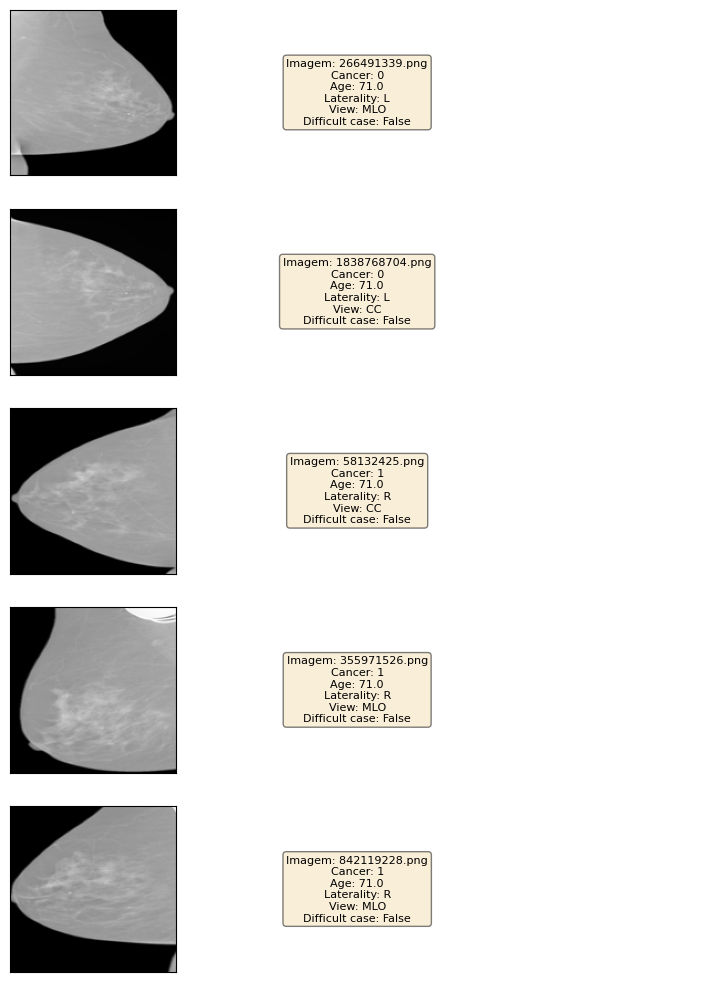

In [85]:
plot_patient_images(
    patient_id=pacientes_com_cancer[0]
)

##### Imagens de um paciente sem câncer

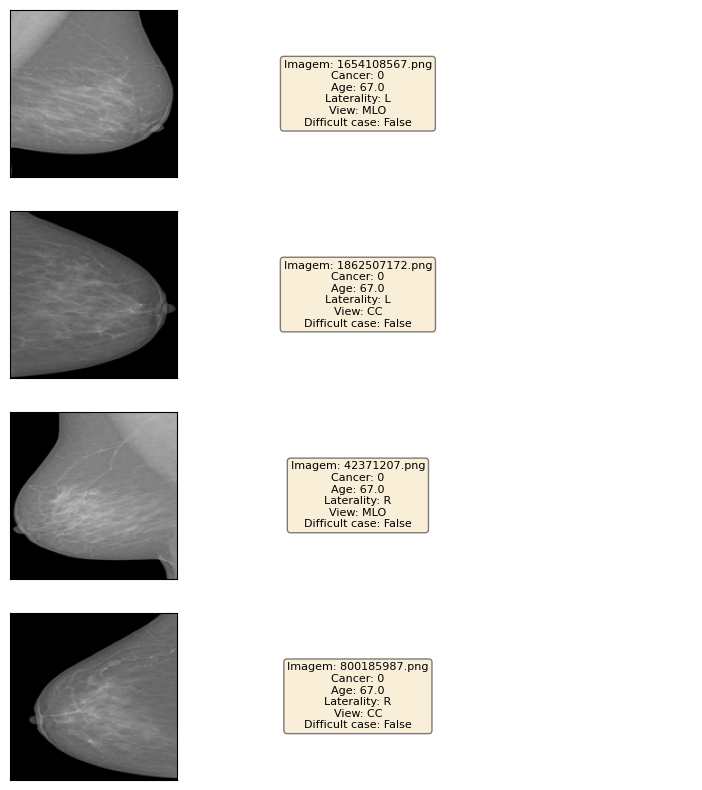

In [86]:
plot_patient_images(
    patient_id=pacientes_sem_cancer[0]
)

##### Imagens de um paciente sem câncer e diagnóstico difícil

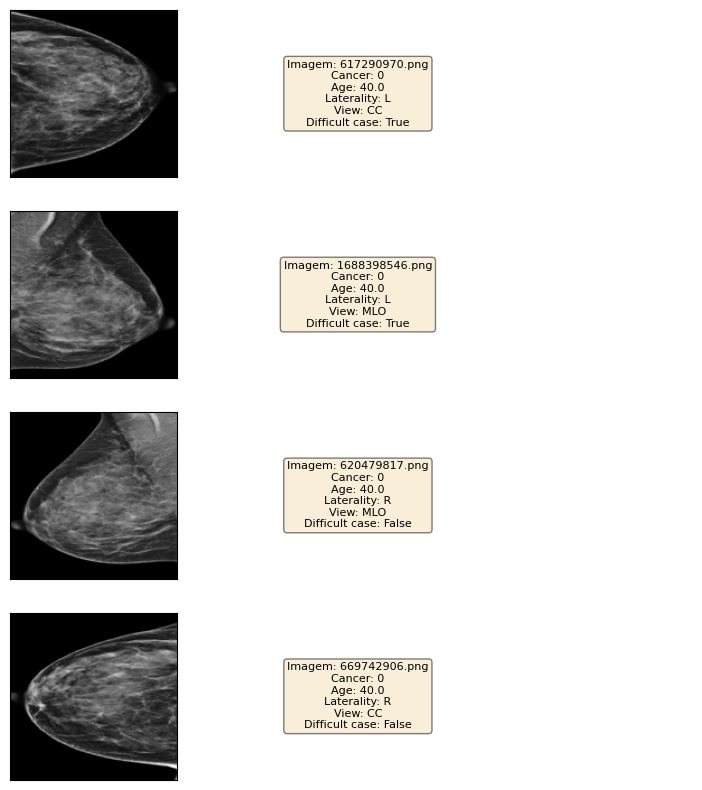

In [87]:
plot_patient_images(
    patient_id=pacientes_sem_cancer_caso_dificil[0]
)

#### Exibição de exemplos de imagens com e sem câncer (128x64)

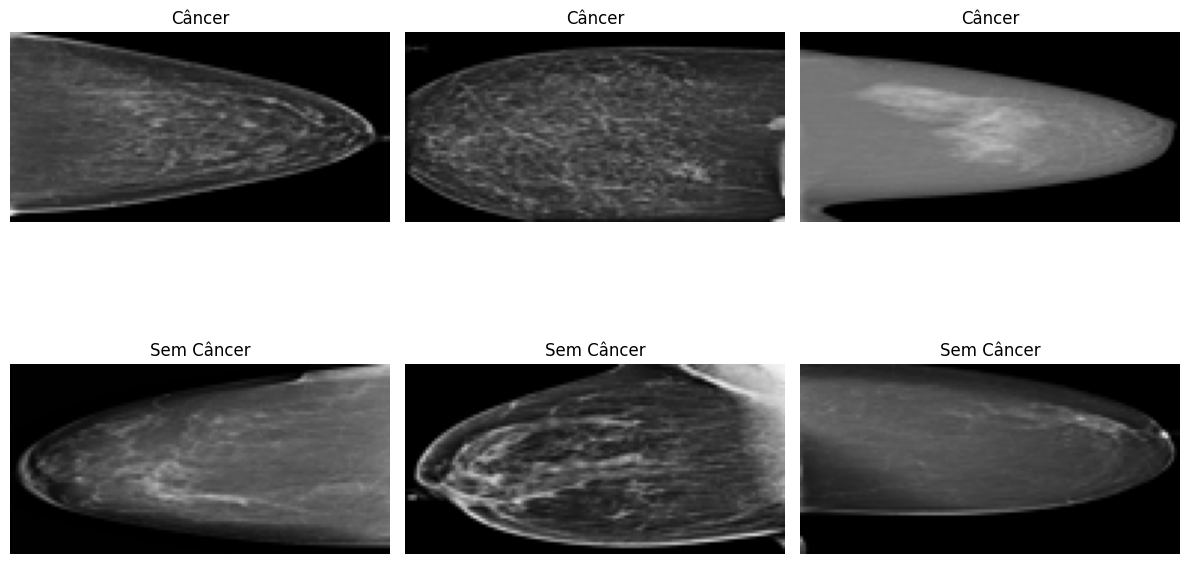

In [88]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Diretório das imagens
image_dir = '/content/files/train'

# Função para carregar as imagens
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

# Função para redimensionar as imagens
def resize_image(image_path):
    image = Image.open(image_path).convert('RGB')
    resized_image = image.resize((128, 64))
    return resized_image

# Lista de imagens positivas (câncer)
positive_dir = os.path.join(image_dir, 'cancer_1')
positive_images = os.listdir(positive_dir)[:3]  # Selecionando as primeiras três imagens

# Lista de imagens negativas (sem câncer)
negative_dir = os.path.join(image_dir, 'cancer_0')
negative_images = os.listdir(negative_dir)[:3]  # Selecionando as primeiras três imagens

# Exibindo as imagens positivas
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, image_name in enumerate(positive_images):
    image_path = os.path.join(positive_dir, image_name)
    image = load_image(image_path)
    resized_image = resize_image(image_path)
    axes[0, i].imshow(resized_image)
    axes[0, i].set_title('Câncer')
    axes[0, i].axis('off')

# Exibindo as imagens negativas
for i, image_name in enumerate(negative_images):
    image_path = os.path.join(negative_dir, image_name)
    image = load_image(image_path)
    resized_image = resize_image(image_path)
    axes[1, i].imshow(resized_image)
    axes[1, i].set_title('Sem Câncer')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Visão geral e significado dos dados

#### Descrições das colunas (site do Kaggle)

 - site_id - ID code for the source hospital.
 - patient_id - ID code for the patient.
 - image_id - ID code for the image.
 - laterality - Whether the image is of the left or right breast.
 - view - The orientation of the image. The default for a screening exam is to capture two views per breast.
 - age - The patient's age in years.
 - implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
 - density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
 - machine_id - An ID code for the imaging device.
 - cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
 - biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
 - invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
 - BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
 - prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
 - difficult_negative_case - True if the case was unusually difficult. Only provided for train.

#### Colunas, quantidade de linhas e valores nulos presentes em cada arquivo(arquivos csv)

#### Arquivo train.csv

 - 43744 linhas;
 - valores nulos presentes apenas em:
   - BIRADS (20959 linhas sem valores nulos);
   - density (23674 linhas sem valores nulos).

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  43744 non-null  int64  
 1   patient_id               43744 non-null  int64  
 2   image_id                 43744 non-null  int64  
 3   laterality               43744 non-null  object 
 4   view                     43744 non-null  object 
 5   age                      43720 non-null  float64
 6   cancer                   43744 non-null  int64  
 7   biopsy                   43744 non-null  int64  
 8   invasive                 43744 non-null  int64  
 9   BIRADS                   20959 non-null  float64
 10  implant                  43744 non-null  int64  
 11  density                  23674 non-null  object 
 12  machine_id               43744 non-null  int64  
 13  difficult_negative_case  43744 non-null  bool   
dtypes: bool(1), float64(2)

In [90]:
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


### Distribuição de pacientes e imagens por diagnóstico

#### Quantidade de imagens e resultados (positivos x negativos)

Resultado: Aproximadamente 2.2% das imagens indicam resultado positivo.

In [91]:
df_gb_size = train.groupby('cancer').size()
df_gb_size

cancer
0    42778
1      966
dtype: int64

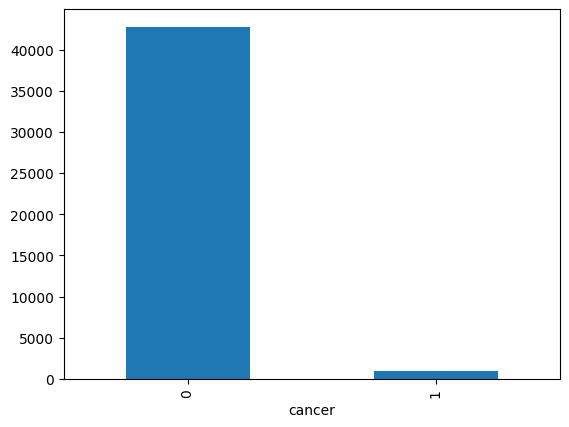

In [92]:
_ = df_gb_size.plot(kind='bar')

#### Resultados por paciente

Resultado: Aproximadamente 4.4% dos pacientes possuem ao menos uma imagem indicando resultado positivo.

In [93]:
df_gb_patient = train.groupby('patient_id')['cancer'].sum().reset_index()
df_gb_patient.loc[df_gb_patient.cancer > 0,'cancer'] = 1
df_gb_patient.groupby('cancer').size()

cancer
0    9124
1     406
dtype: int64

#### Distribuição da idade x resultado positivo

Resultados:
 - Marcação de câncer é mais comuns em faixa etária superior;
 - Mediana da idade do grupo com resultado positivo é aproximadamente 65 anos;
 - Resultados positivos começam próximos aos 40 anos.

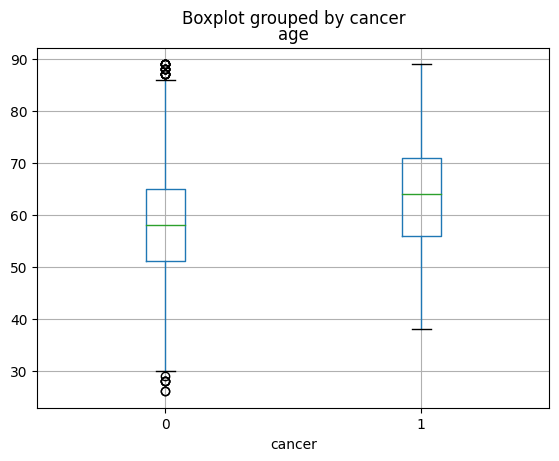

In [94]:
df_patient = train.groupby(['patient_id', 'age'])['cancer'].sum().reset_index()
df_patient.loc[df_patient.cancer > 0,'cancer'] = 1

_ = df_patient.boxplot(column='age', by='cancer')

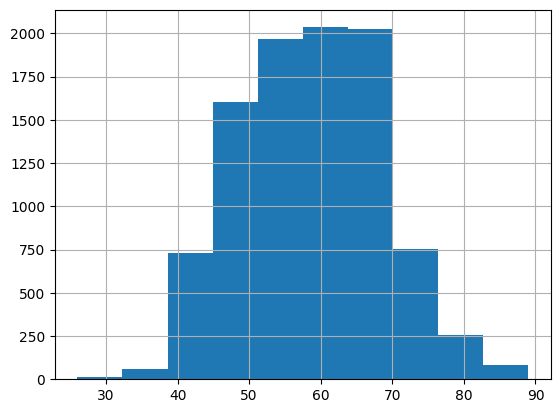

In [95]:
_ = df_patient['age'].hist()

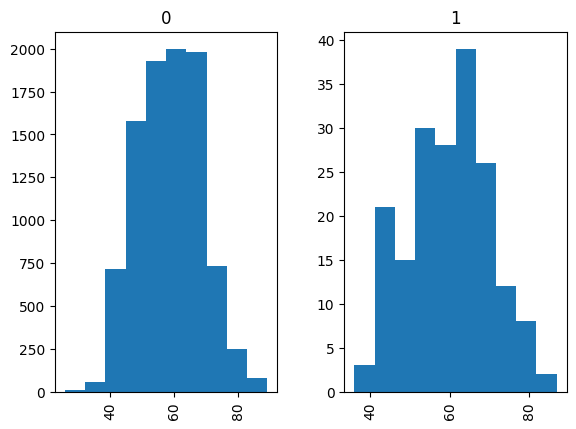

In [96]:
_ = df_patient['age'].hist(
    by=train['cancer'],
    )

#### Analise de pacientes com câncer x implante

Resultado:
 - dos resultados indicados como positivos, há apenas um paciente com implante;

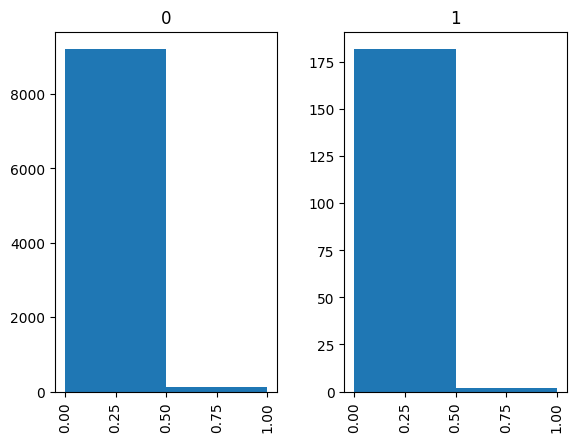

In [97]:
df_patient = train.groupby(['patient_id', 'implant'])['cancer'].sum().reset_index()
df_patient.loc[df_patient.cancer > 0,'cancer'] = 1

_ = df_patient['implant'].hist(
    by=train['cancer'],
    bins=2
    )

In [98]:
df_patient.groupby(['implant', 'cancer']).size().unstack(fill_value=0)

cancer,0,1
implant,,
0,8991,405
1,133,1


In [99]:
train.groupby(['implant', 'cancer']).size().unstack(fill_value=0)

cancer,0,1
implant,,
0,41625,962
1,1153,4


In [100]:
train.groupby(['BIRADS', 'cancer']).size().unstack()

cancer,0,1
BIRADS,,
0.0,6105.0,549.0
1.0,12492.0,NaN
2.0,1813.0,NaN


### Características das imagens
- Temos quase as mesmas quantidades de imagens do lado esquerdo e direito;
- As orientações de imagem com maior ocorrências são CC (21413) e MLO (22302)

In [101]:
train.groupby('laterality').size()

laterality
L    21806
R    21938
dtype: int64

In [102]:
train.groupby('view').size()

view
AT        16
CC     21413
LM         5
LMO        1
ML         7
MLO    22302
dtype: int64

In [103]:
train[train.view == 'AT'].iloc[0]

site_id                             1
patient_id                       2028
image_id                   2082854771
laterality                          R
view                               AT
age                              81.0
cancer                              0
biopsy                              0
invasive                            0
BIRADS                            NaN
implant                             0
density                             A
machine_id                         49
difficult_negative_case         False
Name: 7665, dtype: object

## Etapa 5: Modelo para predição de câncer de mama

### Funções, definições e parâmetros utilizados para facilitar treinamento e avaliação dos modelos

#### Parâmetros globais válidos para todos os modelos
Os valores das variáveis declaradas neste comando devem ser alterados conforme necessidade.

In [120]:
test_images_folder = '/content/files/test'
train_images_folder = '/content/files/train'
validation_images_folder = '/content/files/validation'

# incluir parâmetros adicionais para testar outros tipos de processamento
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_generator_parameters_dict = {
    'shear_range':0.2,
    'zoom_range':0.2,
    'horizontal_flip':True}


NUM_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 1000

#### Criação de métricas utilizadas antes e depois do treinamento

In [121]:
import tensorflow as tf
class CategoricalTruePositives(tf.keras.metrics.Metric):

    def __init__(self, num_classes, batch_size,
                 name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes

        self.cat_true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):

        y_true = tf.keras.backend.argmax(y_true, axis=-1)
        y_pred = tf.keras.backend.argmax(y_pred, axis=-1)
        y_true = tf.keras.backend.flatten(y_true)

        true_poss = tf.keras.backend.sum(tf.keras.backend.cast((tf.keras.backend.equal(y_true, y_pred)), dtype=tf.float32))

        self.cat_true_positives.assign_add(true_poss)

    def result(self):

        return self.cat_true_positives
# referências:
# https://aclanthology.org/2020.eval4nlp-1.9.pdf
# https://www.kaggle.com/code/sohier/probabilistic-f-score
# https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/369267
class pFBeta(tf.keras.metrics.Metric):
    """Compute overall probabilistic F-beta score."""
    def __init__(self, beta=1, epsilon=1e-5, name='pfbeta', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = epsilon
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.reduce_sum(y_true)
        ctp = tf.reduce_sum(y_pred[y_true==1])
        cfp = tf.reduce_sum(y_pred[y_true==0])
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)

    def result(self):
        beta_squared = self.beta * self.beta
        c_precision = self.ctp / (self.ctp + self.cfp + self.epsilon)
        c_recall = self.ctp / (self.pos + self.epsilon)
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return tf.cond(c_precision > 0 and c_recall > 0, lambda: result, lambda: 0.0)



metrics = [
      CategoricalTruePositives(NUM_CLASSES, BATCH_SIZE),
      pFBeta(name='probabilistic-f-score'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

binary_metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      pFBeta(name='probabilistic-f-score'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


#### Declaração de funções para visualização de resultados

In [122]:
# visualize confusion matrix on heat map
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_cmx(
    y_true,
    y_pred,
    labels = ["Sem Câncer", "Com Câncer"],
    save_fig_path = "",
    title = "Confusion Matrix"):
    cmx_data = confusion_matrix(y_true, y_pred, normalize='true')

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.title(title)
    if (save_fig_path != "") and (TRAIN_MODEL == True):
        plt.savefig(save_fig_path)

    plt.show()

In [123]:
from sklearn.metrics import roc_curve, auc

def plot_and_save_roc_curve(y_true, preds, save_fig_path = "", title = "ROC"):
    fpr, tpr, _ = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2

    plt.plot(
        fpr,
        tpr,
        color='darkorange',
        lw=lw,
        label='ROC curve (area = %0.2f)' % roc_auc)

    plt.plot(
        [0, 1],
        [0, 1],
        color='navy',
        lw=lw,
        linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if (save_fig_path != "") and (TRAIN_MODEL == True):
        plt.savefig(save_fig_path)
    plt.show()

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_curve
import os

def plot_using_model_history(history_f):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(data=history_f[['loss', 'val_loss']], ax=ax[0])
    ax[0].set_title('Evolução da função de perda (loss)')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Loss')

    sns.lineplot(data=history_f[['accuracy', 'val_accuracy']], ax=ax[1])
    ax[1].set_title('Evolução da acurácia')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Acurácia')

    plt.show()

# referências:
# https://aclanthology.org/2020.eval4nlp-1.9.pdf
# https://www.kaggle.com/code/sohier/probabilistic-f-score
# https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/369267
def pfbeta(labels, predictions, beta = 1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

def pfbeta_np(labels, preds, beta=1):
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0



def evaluate_image_set(model, image_generator, title, save_fig_path = ""):

    # Confusion Matrix and Classification Report
    Y_pred = model.predict(image_generator)
    y_pred = np.argmax(Y_pred, axis=-1)
    print(f'Classification Report - {title}')
    target_names = ['Sem Câncer', 'Câncer']
    print(classification_report(image_generator.classes, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(image_generator.classes, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalization
    cm_df = pd.DataFrame(cm_normalized, index=target_names, columns=target_names)

    # Confusion Matrix
    metrica_kaggle = pfbeta(image_generator.classes, Y_pred)
    print(f'Métrica de avaliação do Kaggle - {metrica_kaggle}')

    metrica_kaggle = pfbeta_np(image_generator.classes, Y_pred)
    print(f'Métrica de avaliação do Kaggle (numpy) - {metrica_kaggle}')

    pf_metric = pFBeta()
    pf_metric.update_state(image_generator.classes, Y_pred)
    print('Métrica de avaliação do Kaggle (keras):', float(pf_metric.result()))

    acuracia_balanceada = balanced_accuracy_score(image_generator.classes, y_pred)
    print(f'Acurácia balanceada: {100*acuracia_balanceada:.2f}%')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Normalized Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if save_fig_path != "" and (TRAIN_MODEL == True):
        plt.savefig(save_fig_path)

    plt.show()


def evaluate_image_set_binary(model, image_generator, title, save_fig_path = ""):

    folder = os.path.dirname(save_fig_path)
    file_name_sufix = title.lower().replace(' ', '-')

    # Confusion Matrix and Classification Report
    y_pred = model.predict(image_generator)
    preds=np.transpose(y_pred)[0]  # transformation to get (n,)
    print(preds.shape)  # now the shape is (n,)
    # Applying transformation to get binary values predictions with 0.5 as thresold
    seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, preds))
    #print(f'Classification Report - {title}')
    target_names = ['Sem Câncer', 'Câncer']

    metrica_kaggle = pfbeta_np(image_generator.classes, preds)
    print(f'Métrica de avaliação do Kaggle: {metrica_kaggle}')

    acuracia_balanceada = balanced_accuracy_score(
        image_generator.classes,
        seq_predictions)
    print(f'Acurácia balanceada: {100*acuracia_balanceada:.2f}%')

    print(classification_report(
        image_generator.classes,
        seq_predictions,
        target_names=target_names))

    print_cmx(
        image_generator.classes,
        seq_predictions,
        save_fig_path=f"{folder}/cm-{file_name_sufix}.png",
        title=f"Matriz de confusão - {title}"
        )

    plot_and_save_roc_curve(
        image_generator.classes,
        preds,
        save_fig_path=f"{folder}/roc-{file_name_sufix}.png",
        title=f"Curva ROC - {title}"
        )



#### Declaração de função para criar gerador de imagem para cada conjunto de dado

In [125]:



def create_image_data_generator(preprocessing_function, generator_parameters_dict = {}):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        **generator_parameters_dict)


def create_generators(
    preprocessing_function,
    target_size = TARGET_SIZE,
    train_generator_parameters = train_generator_parameters_dict,
    class_mode = 'categorical',
    shuffle_train = True):

    train_datagen = create_image_data_generator(
        preprocessing_function=preprocessing_function,
        generator_parameters_dict = train_generator_parameters_dict
    )

    train_generator = train_datagen.flow_from_directory(
            train_images_folder,
            target_size=target_size,
            batch_size=BATCH_SIZE,
            class_mode=class_mode,
            shuffle=shuffle_train)


    test_datagen = create_image_data_generator(
        preprocessing_function=preprocessing_function
    )

    test_generator = test_datagen.flow_from_directory(
        test_images_folder,
        target_size=target_size,
        batch_size=BATCH_SIZE,
        class_mode=class_mode,
        shuffle=False)

    validation_datagen = create_image_data_generator(
        preprocessing_function=preprocessing_function
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_images_folder,
        target_size=target_size,
        batch_size=BATCH_SIZE,
        class_mode=class_mode,
        shuffle=False)

    return train_generator, test_generator, validation_generator



#### Criação de create_callbacks utilizados durante treinamento

In [126]:
import shutil
from keras.callbacks import Callback

def create_callbacks(checkpoint_dir, remove_checkpoint = False):
    if remove_checkpoint == True:
        # limpa diretorio de destino contendo o melhor
        shutil.rmtree(f'{checkpoint_dir}/best/', ignore_errors=True)

    # model checkpoint call back
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{checkpoint_dir}/best/cp.ckpt',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    # model checkpoint call back
    last_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{checkpoint_dir}/last/cp.ckpt',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=False)


    # Early Stopping
    early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True)

    csv_callback = tf.keras.callbacks.CSVLogger(
        filename = f'{checkpoint_dir}/training_history.csv',
        separator=',',
        append=True
    )


    return [best_checkpoint,last_checkpoint, early, csv_callback]


#### Calcula pesos das classes (para considerar grande desbalanceamento)

In [127]:
from collections import Counter

train_generator, test_generator, validation_generator = create_generators(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    target_size = TARGET_SIZE,
    class_mode = 'binary'
)

counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
train_class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
train_class_weights

Found 34956 images belonging to 2 classes.
Found 10947 images belonging to 2 classes.
Found 8731 images belonging to 2 classes.


{0: 1.0, 1: 45.73262032085562}

#### Função para salvar resultado do modelo

In [128]:
def save_model(model, checkpoints_path):
    # Salva o modelo no formato SavedModel
    saved_model_path = f"{checkpoints_path}model.keras"
    model.save(saved_model_path)

    print("Modelo salvo com sucesso em:", saved_model_path)

#### Função para rodar sequência de treino e avaliação com modelo do Keras
Etapas incluídas nesta sequência:

 A. Se o modelo deve ser treinado do zero (run_model_fit = True):
  1. Criação de checkpoints;
  2. Criação de image_generator;
  3. Gera imagem da arquiterua do modelo.

B. Com o modelo carregado (caso fit seja habilitado):
  1. Carrega último checkpoint se houver;
  2. Roda treino até completar número de épocas ou critério do early stop;

C. Com o treino concluído (ou fit desabilitado):
  1. Avaliação no conjunto de validação e teste;
  2. Apresenta e salva matriz de confusão e principais métricas;
  3. Impressão da curva Roc.

In [129]:
from keras.utils.vis_utils import plot_model


def run_keras_train_and_evaluate(
    model,
    train_class_weights,
    model_identification,
    preprocessing_function,
    n_epochs = N_EPOCHS,
    run_model_fit = False,
    load_best_checkpoint = True,
    checkpoints_path=CHECKPOINTS_FOLDER,
    target_size = TARGET_SIZE,
    loss_function = 'categorical_crossentropy',
    optimizer_class = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics_list = metrics,
    generator_class_mode='categorical',
    evaluate_image_set_function = evaluate_image_set):

    checkpoint_path = f"{CHECKPOINTS_FOLDER}{model_identification}/"
    print('creating generators')
    train_generator, test_generator, validation_generator = create_generators(
        preprocessing_function = preprocessing_function,
        target_size = target_size,
        class_mode = generator_class_mode
    )

    # Check whether the specified path exists or not
    isExist = os.path.exists(checkpoint_path)
    if (not isExist) and (TRAIN_MODEL == True):
      # Create a new directory because it does not exist
      os.makedirs(checkpoint_path)


    if (TRAIN_MODEL == True):
      print('ploting model')
      plot_model(
          model,
          to_file=f'{CHECKPOINTS_FOLDER}{model_identification}/model_plot.png',
          show_shapes=True,
          show_layer_names=True)

    print('compiling model')
    model.compile(
        optimizer=optimizer_class,
        loss=loss_function,
        metrics=metrics_list,
        weighted_metrics=['accuracy'])

    best_checkpoint_path = f'{checkpoint_path}best/'
    best_checkpoint_filepath = f'{best_checkpoint_path}cp.ckpt'
    if (load_best_checkpoint) & (os.path.exists(best_checkpoint_path)):
        try:
            print('loading best weights')
            model.load_weights(best_checkpoint_filepath)
            print('loaded best weights')
        except:
            print('error loading weights, trying to load model')
            model = tf.keras.saving.load_model(f"{best_checkpoint_path}model.keras")
            print('load model success')
            pass
    history_csv_path = f'{checkpoint_path}training_history.csv'
    if run_model_fit:

        initial_epoch = 0
        try:
            training_history = pd.read_csv(history_csv_path)
            initial_epoch = len(training_history.index)
            print(f'initial_epoch: {initial_epoch}')
        except:
            print('error loading initial epoch')
            initial_epoch = 0
            pass

        model_callbacks = create_callbacks(checkpoint_path)

        last_checkpoint_path = f'{checkpoint_path}last/'
        last_checkpoint_filepath = f'{best_checkpoint_path}cp.ckpt'
        if (os.path.exists(last_checkpoint_path)):
            print('loading last weights')
            model.load_weights(last_checkpoint_filepath)
            print('loaded last weights')
        print('start model fit')
        fit_history = model.fit(
            train_generator,
            epochs=n_epochs + initial_epoch,
            callbacks=model_callbacks,
            validation_data=validation_generator,
            class_weight=train_class_weights,
            initial_epoch=initial_epoch)
        print('end of model fit')

        model.load_weights(best_checkpoint_filepath)
        try:
            save_model(
                model,
                checkpoints_path=best_checkpoint_path)
        except:
            print('error during save model')

    history_f = pd.read_csv(history_csv_path)
    plot_using_model_history(history_f)


    print('Evaluating Validation set')
    evaluate_image_set_function(
        model = model,
        image_generator = validation_generator,
        title='Validation set',
        save_fig_path = f'{checkpoint_path}cm-validation-set.png')


    print('Evaluating Test set')
    evaluate_image_set_function(
        model = model,
        image_generator = test_generator,
        title='Test set',
        save_fig_path = f'{checkpoint_path}cm-test-set.png')

    return model


### 1° arquitetura avaliada (EfficientNetB0 pré treinada com imagenet)

In [ ]:
# Carregamento do modelo pré-treinado SEM a última camada densa (include_top = False)
base_model_m1 = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3))
base_model_m1.summary()

# Congela camadas pré-treinadas
for layer in base_model_m1.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
#model_m1 = tf.keras.Sequential([
#  base_model_m1,
#  tf.keras.layers.GlobalAveragePooling2D(),
# tf.keras.layers.Dense(2, activation='softmax')
#])

# Insere novas camadas no fim da rede para classificação
model_m1 = tf.keras.Sequential([
  base_model_m1,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


model_m1.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 512, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

creating generators
Found 34956 images belonging to 2 classes.
Found 10947 images belonging to 2 classes.
Found 8731 images belonging to 2 classes.
ploting model
compiling model
loading best weights
loaded best weights


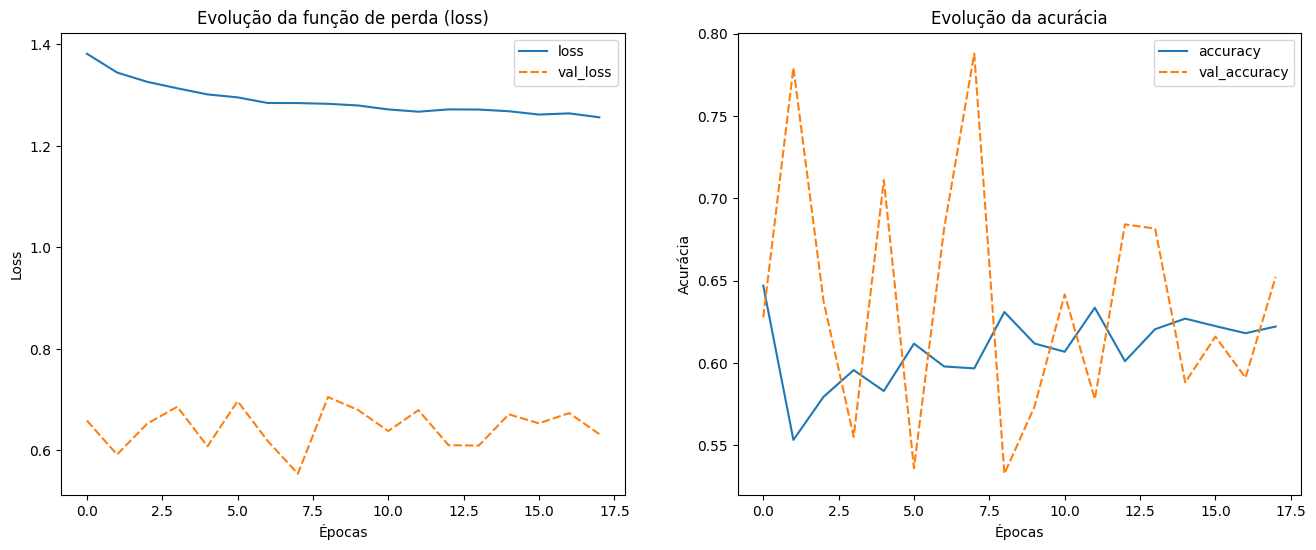

Evaluating Validation set
273/273 [==============================] - 43s 144ms/step
(8731,)
Métrica de avaliação do Kaggle: 0.05132107009640905
Acurácia balanceada: 54.36%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.92      0.95      8514
      Câncer       0.05      0.17      0.08       217

    accuracy                           0.90      8731
   macro avg       0.51      0.54      0.51      8731
weighted avg       0.95      0.90      0.92      8731



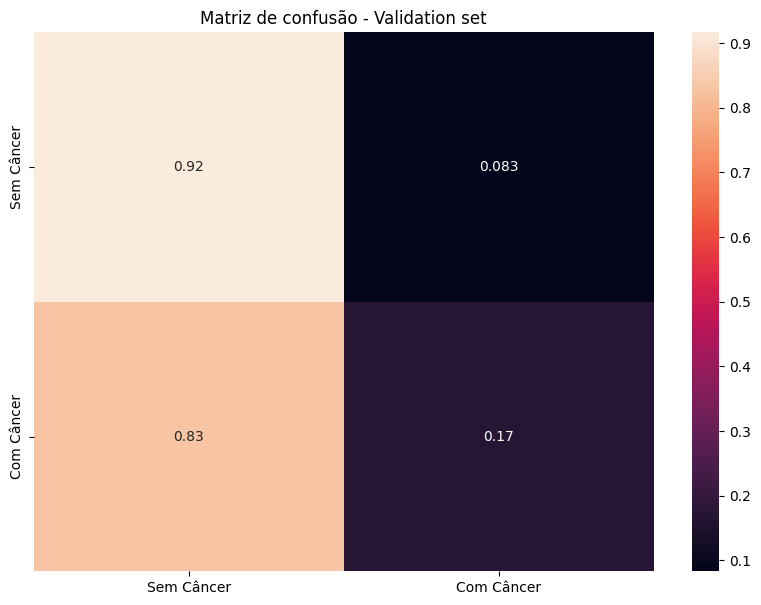

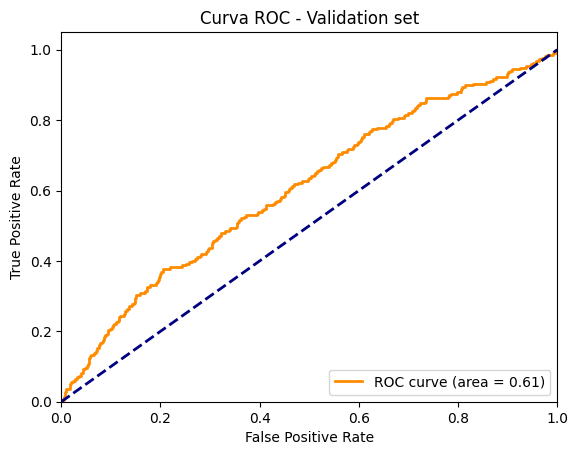

Evaluating Test set
343/343 [==============================] - 43s 125ms/step
(10947,)
Métrica de avaliação do Kaggle: 0.03648269946715666
Acurácia balanceada: 53.96%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.91      0.94     10755
      Câncer       0.03      0.17      0.05       192

    accuracy                           0.89     10947
   macro avg       0.51      0.54      0.50     10947
weighted avg       0.97      0.89      0.93     10947



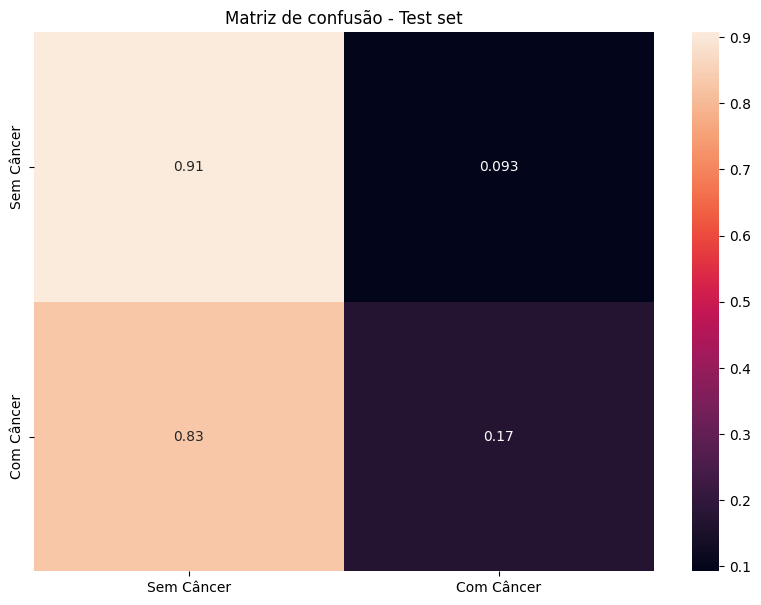

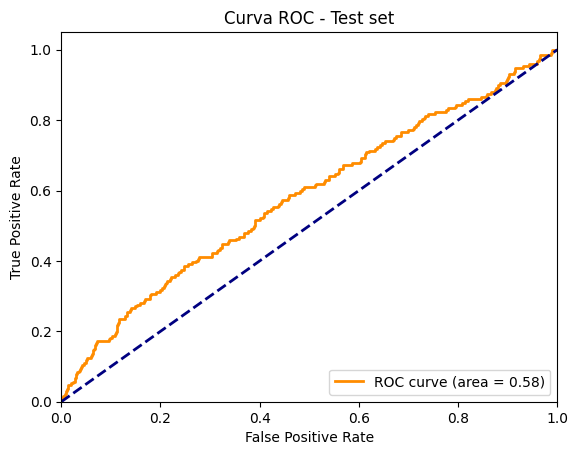

In [ ]:
md = run_keras_train_and_evaluate(
    model = model_m1,
    train_class_weights = train_class_weights,
    model_identification = 'efficientnetb0-congelado',
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    run_model_fit = False,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)

### 2° Arquitetura avaliada (efficientnetb0 com camadas descongeladas)

In [ ]:
# descongelando os pesos da rede
for layer in base_model_m1.layers:
    layer.trainable = True

# Insere novas camadas no fim da rede para classificação
model_m2 = tf.keras.Sequential([
  base_model_m1,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


model_m2.summary() #Note o número de paramêtros treináveis

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 16, 1280)      4049571   
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
run_keras_train_and_evaluate(
    model = model_m2,
    train_class_weights = train_class_weights,
    model_identification = 'efficientnetb0-descongelado',
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    run_model_fit = TRAIN_MODEL,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)



### 3° Arquitetura avaliada (densenet121 com camadas congeladas)

In [ ]:
!pip install tensorflow-addons

# Carregamento do modelo pré-treinado SEM a última camada densa (include_top = False)
base_model_desnet = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3))
base_model_desnet.summary()

# Congela camadas pré-treinadas
for layer in base_model_desnet.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
model_desnet = tf.keras.Sequential([
  base_model_desnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_desnet.summary()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.9 MB/s eta 0:00:00
29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 64, 64)  9408        ['zero_padding2d[0][0]']         
                                         

In [ ]:
run_keras_train_and_evaluate(
    model = model_desnet,
    train_class_weights = train_class_weights,
    model_identification = 'densenet121-congelado',
    preprocessing_function = tf.keras.applications.densenet.preprocess_input ,
    run_model_fit = TRAIN_MODEL,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)

### 4° Arquitetura avaliada (densenet121 com camadas descongeladas)

In [ ]:
# descongelando os pesos da rede
for layer in base_model_desnet.layers:
    layer.trainable = True

model_desnet_desc = tf.keras.Sequential([
  base_model_desnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_desnet_desc.summary() #Note o núúmero de paramêtros treináveis

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


creating generators
Found 34956 images belonging to 2 classes.
Found 10947 images belonging to 2 classes.
Found 8731 images belonging to 2 classes.
ploting model
compiling model
loading best weights
loaded best weights


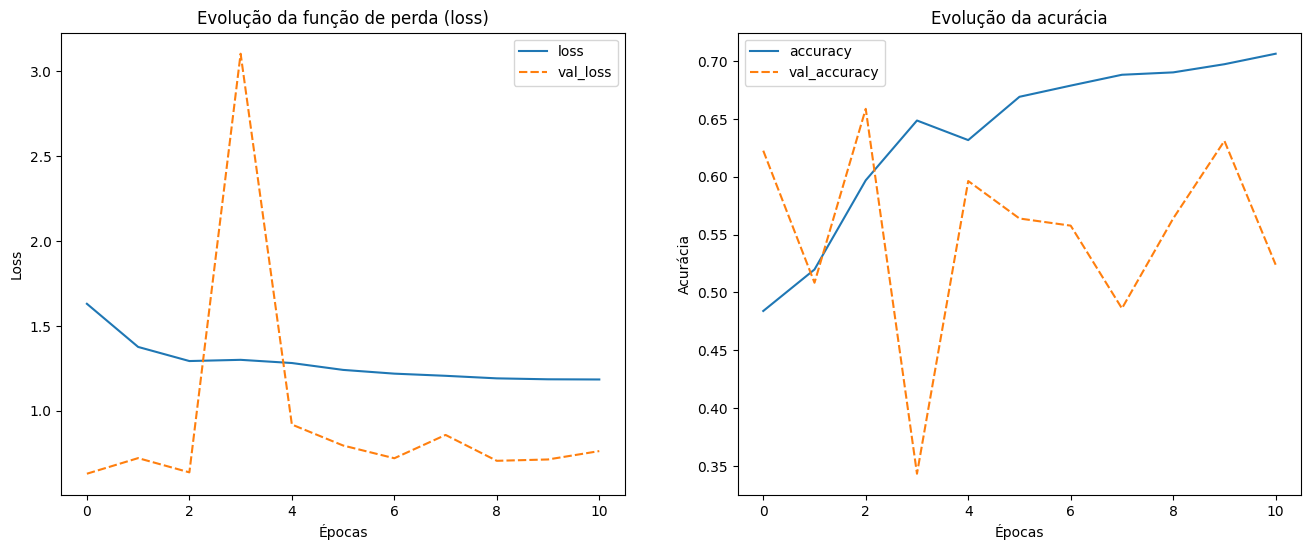

Evaluating Validation set
273/273 [==============================] - 47s 129ms/step
(8731,)
Métrica de avaliação do Kaggle: 0.0500839046619457
Acurácia balanceada: 58.51%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.79      0.87      8514
      Câncer       0.04      0.38      0.08       217

    accuracy                           0.78      8731
   macro avg       0.51      0.59      0.48      8731
weighted avg       0.96      0.78      0.85      8731



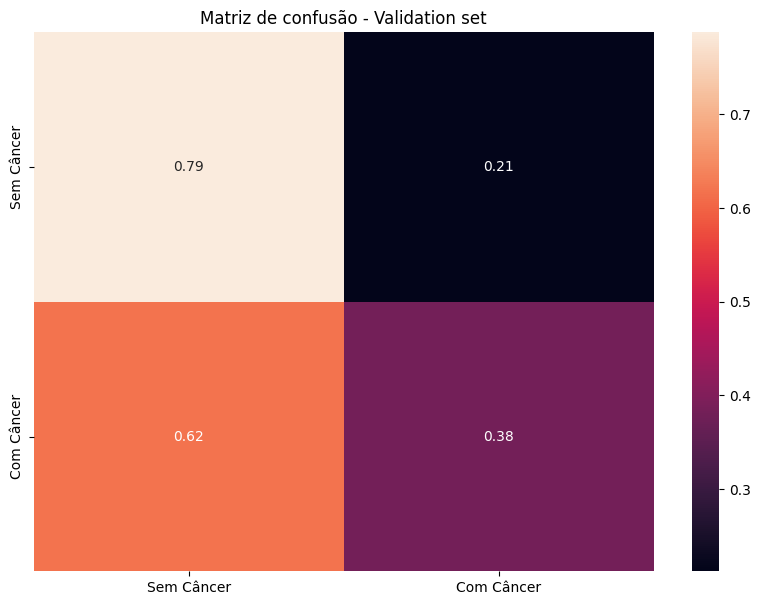

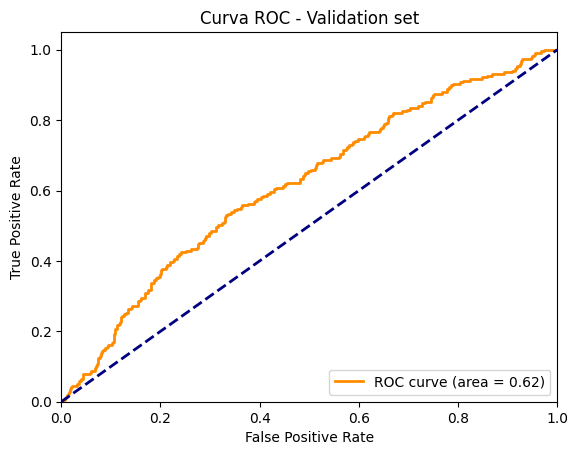

Evaluating Test set
343/343 [==============================] - 41s 119ms/step
(10947,)
Métrica de avaliação do Kaggle: 0.03503285502398582
Acurácia balanceada: 55.21%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.78      0.87     10755
      Câncer       0.03      0.33      0.05       192

    accuracy                           0.77     10947
   macro avg       0.51      0.55      0.46     10947
weighted avg       0.97      0.77      0.85     10947



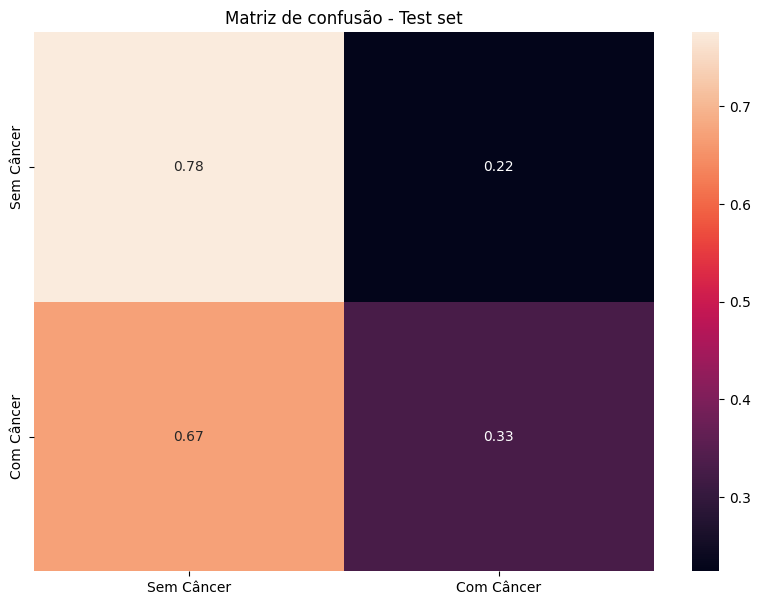

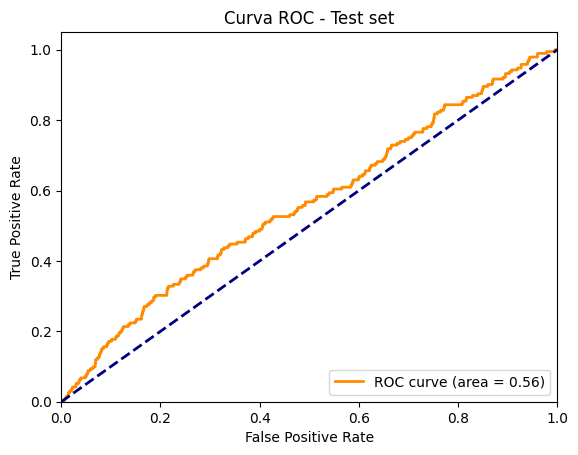

In [ ]:
run_keras_train_and_evaluate(
    model = model_desnet_desc,
    train_class_weights = train_class_weights,
    model_identification = 'densenet121-descongelado',
    preprocessing_function = tf.keras.applications.densenet.preprocess_input,
    run_model_fit = TRAIN_MODEL,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)

### 5° Arquitetura avaliada (ResNet50 com camadas congeladas)

In [ ]:
# Carregamento do modelo pré-treinado SEM a última camada densa (include_top = False)
base_model_resnet = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3))
base_model_resnet.summary()

# Congela camadas pré-treinadas
for layer in base_model_resnet.layers:
    layer.trainable = False

# Inserir as novas camadas no fim da rede para classificação
model_resnet = tf.keras.Sequential([
  base_model_resnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 128, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 128, 64)  256         ['conv1_conv[0][0]']      

In [ ]:
run_keras_train_and_evaluate(
    model = model_desnet,
    train_class_weights = train_class_weights,
    model_identification = 'resnet50-congelado',
    preprocessing_function = tf.keras.applications.resnet.preprocess_input ,
    run_model_fit = TRAIN_MODEL,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)

### 6° Arquitetura avaliada (ResNet50 com camadas descongeladas)

In [ ]:
# descongelando os pesos da rede
for layer in base_model_resnet.layers:
    layer.trainable = True

model_resnet_desc = tf.keras.Sequential([
  base_model_resnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_resnet_desc.summary() #Note o núúmero de paramêtros treináveis

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


creating generators
Found 34996 images belonging to 2 classes.
Found 10962 images belonging to 2 classes.
Found 8748 images belonging to 2 classes.
ploting model
compiling model
loading best weights
loaded best weights


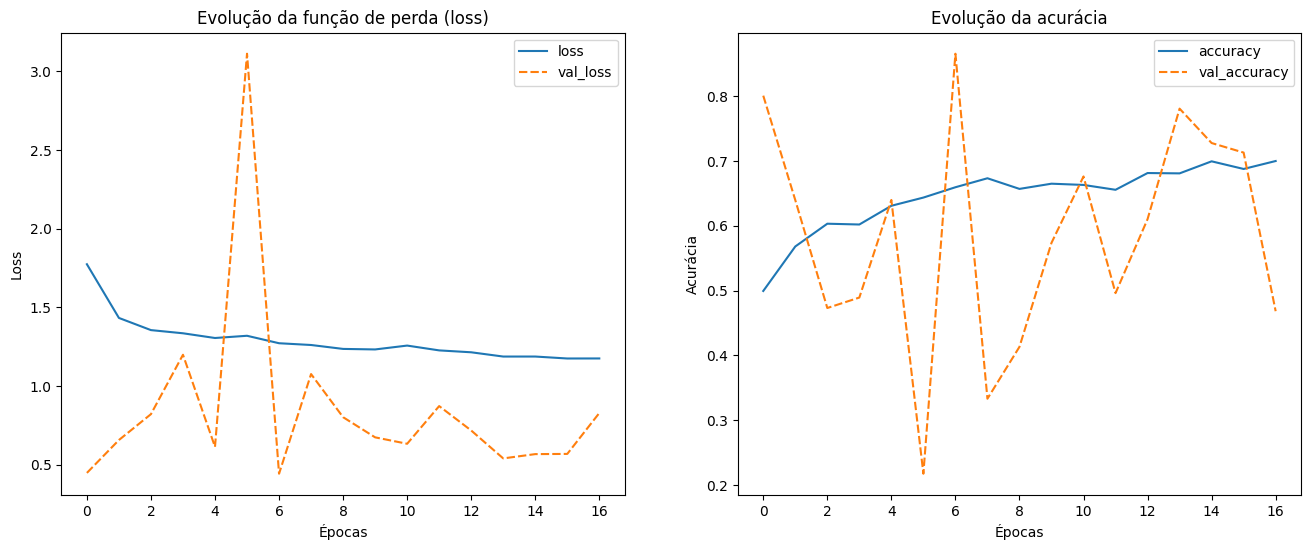

Evaluating Validation set
274/274 [==============================] - 41s 145ms/step
(8748,)
Métrica de avaliação do Kaggle: 0.05313121196185061
Acurácia balanceada: 54.88%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.88      0.93      8530
      Câncer       0.04      0.22      0.07       218

    accuracy                           0.87      8748
   macro avg       0.51      0.55      0.50      8748
weighted avg       0.95      0.87      0.91      8748



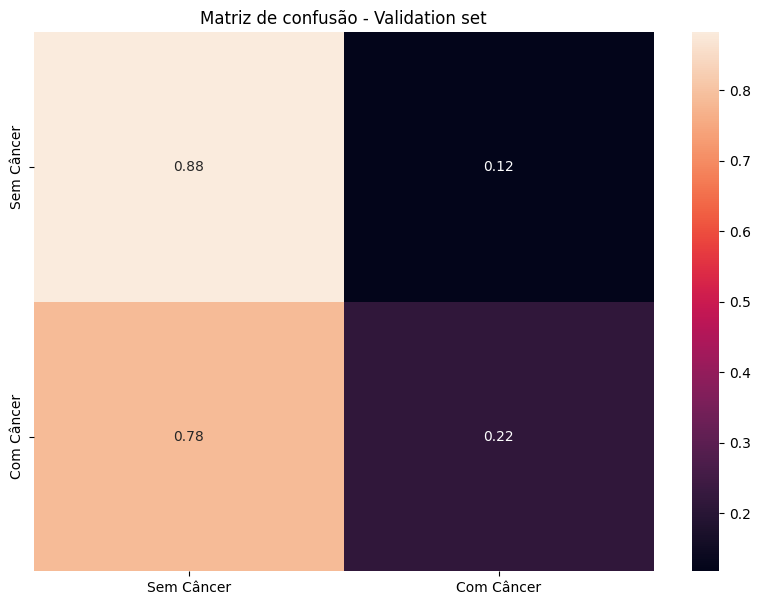

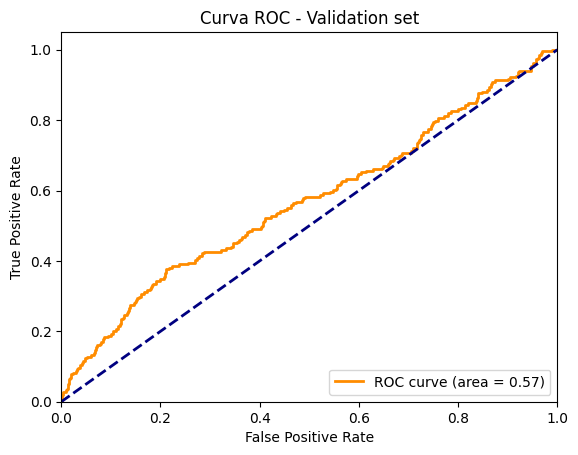

Evaluating Test set
343/343 [==============================] - 47s 136ms/step
(10962,)
Métrica de avaliação do Kaggle: 0.03827172050407345
Acurácia balanceada: 55.01%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.88      0.93     10770
      Câncer       0.03      0.22      0.05       192

    accuracy                           0.86     10962
   macro avg       0.51      0.55      0.49     10962
weighted avg       0.97      0.86      0.91     10962



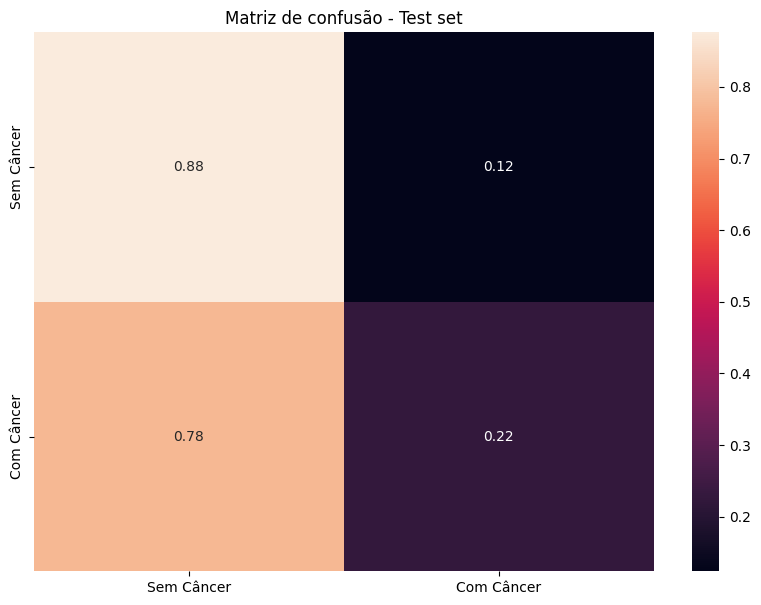

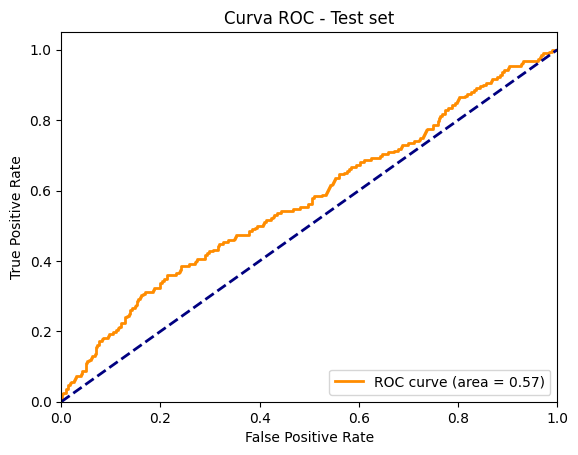

In [ ]:
run_keras_train_and_evaluate(
    model = model_resnet_desc,
    train_class_weights = train_class_weights,
    model_identification = 'resnet50-descongelado',
    preprocessing_function = tf.keras.applications.resnet.preprocess_input,
    run_model_fit = False,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)

In [ ]:
!kill $(ps aux | awk '{print $2}')

### 7° Arquitetura (ConvNeXtLarge como extrator de features)

#### Carregamento do modelo pré treinado ConvNextLarge

In [ ]:
# carregamento de ConvNextLarge (https://keras.io/api/applications/convnext/#convnextlarge-function)
# Carregamento do modelo pré-treinado SEM a última camada densa (include_top = False)
base_model_feat_extractor = tf.keras.applications.ConvNeXtLarge(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3))
# base_model.summary()


for layer in base_model_feat_extractor.layers:
    layer.trainable = False

frozen_model_feat_extractor = tf.keras.Sequential([
  base_model_feat_extractor,
  tf.keras.layers.GlobalAveragePooling2D()
])

785596384/785596384 [==============================] - 30s 0us/step


In [ ]:
frozen_model_feat_extractor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_large (Functional)  (None, 4, 8, 1536)       196230336 
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 196,230,336
Trainable params: 0
Non-trainable params: 196,230,336
_________________________________________________________________


#### Carregamento gerador de imagens utilizando função de pré-processamento do ConvNext

In [ ]:
train_generator, test_generator, validation_generator = create_generators(
    preprocessing_function = tf.keras.applications.convnext.preprocess_input,
    target_size = TARGET_SIZE,
    class_mode = 'binary',
    shuffle_train = True
)

Found 34996 images belonging to 2 classes.
Found 10962 images belonging to 2 classes.
Found 8748 images belonging to 2 classes.


#### Armazena features para evitar carregar toda vez

In [ ]:
def save_numpy(output_path , content_array):
    with open(output_path, 'wb') as f:
        np.save(
        f,
        content_array)

def load_numpy(output_path):
    with open(output_path, 'rb') as f:
        content_array = np.load(f)
    return content_array

# Check whether the specified path exists or not
numpy_dir = f"{CHECKPOINTS_FOLDER}feature_extractors"
isExist = os.path.exists(numpy_dir)

# se diretorio existe, carrega dos arquivos já salvos
if isExist:
    feats_train = load_numpy(f"{CHECKPOINTS_FOLDER}feature_extractors/train_convnextlarge.npy")
    feats_val = load_numpy(f"{CHECKPOINTS_FOLDER}feature_extractors/val_convnextlarge.npy")
    feats_test = load_numpy(f"{CHECKPOINTS_FOLDER}feature_extractors/test_convnextlarge.npy")
    y_train = load_numpy(f"{CHECKPOINTS_FOLDER}feature_extractors/y_train.npy")
    y_val = load_numpy(f"{CHECKPOINTS_FOLDER}feature_extractors/y_val.npy")
    y_test = load_numpy(f"{CHECKPOINTS_FOLDER}feature_extractors/y_test.npy")

if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(numpy_dir, exist_ok = True)

    feats_train = frozen_model_feat_extractor.predict(train_generator)
    y_train =  train_generator.classes
    feats_val = frozen_model_feat_extractor.predict(validation_generator)
    y_val =  validation_generator.classes
    feats_test = frozen_model_feat_extractor.predict(test_generator)
    y_test =  test_generator.classes

    save_numpy(
        output_path = f"{CHECKPOINTS_FOLDER}feature_extractors/train_convnextlarge.npy",
        content_array = feats_train
    )

    save_numpy(
        output_path = f"{CHECKPOINTS_FOLDER}feature_extractors/val_convnextlarge.npy",
        content_array = feats_val
    )

    save_numpy(
        output_path = f"{CHECKPOINTS_FOLDER}feature_extractors/test_convnextlarge.npy",
        content_array = feats_test
    )


    save_numpy(
        output_path = f"{CHECKPOINTS_FOLDER}feature_extractors/y_train.npy",
        content_array = y_train
    )

    save_numpy(
        output_path = f"{CHECKPOINTS_FOLDER}feature_extractors/y_val.npy",
        content_array = y_val
    )

    save_numpy(
        output_path = f"{CHECKPOINTS_FOLDER}feature_extractors/y_test.npy",
        content_array = y_test
    )



343/343 [==============================] - 230s 671ms/step


#### Trata desbalanceamento de features utilizando SMOTE

In [ ]:
# usar tecnicas de balanceamento de dados
!pip install imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(random_state=42)
feats_train_bal, y_train_bal = sm.fit_resample(feats_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_bal))


Original dataset shape Counter({0: 34248, 1: 748})
Resampled dataset shape Counter({0: 34248, 1: 34248})


#### Busca melhores hiperparâmetros utilizando Gridsearch
 - a variável parameters deve ser alterada conforme a necessidade

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": [3, None],
              "max_features": [1, 3, 10, 50],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [10, 20, 50]}

parameters = {"max_depth": [5,],
              "max_features": [50, ],
              "min_samples_split": [2,],
              "min_samples_leaf": [1,],
              "bootstrap": [False,],
              "criterion": ["entropy",],
              "n_estimators": [50,]}


rclf = RandomForestClassifier()
rgclf = GridSearchCV(rclf, param_grid=parameters)
rgclf.fit(feats_train_bal, y_train_bal)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'criterion': ['entropy'],
                         'max_depth': [5], 'max_features': [50],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [50]})

In [ ]:
rclf = rgclf.best_estimator_
rclf.fit(feats_train_bal, y_train_bal)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=5,
                       max_features=50, n_estimators=50)

#### Avaliação de resultados no conjunto de validação

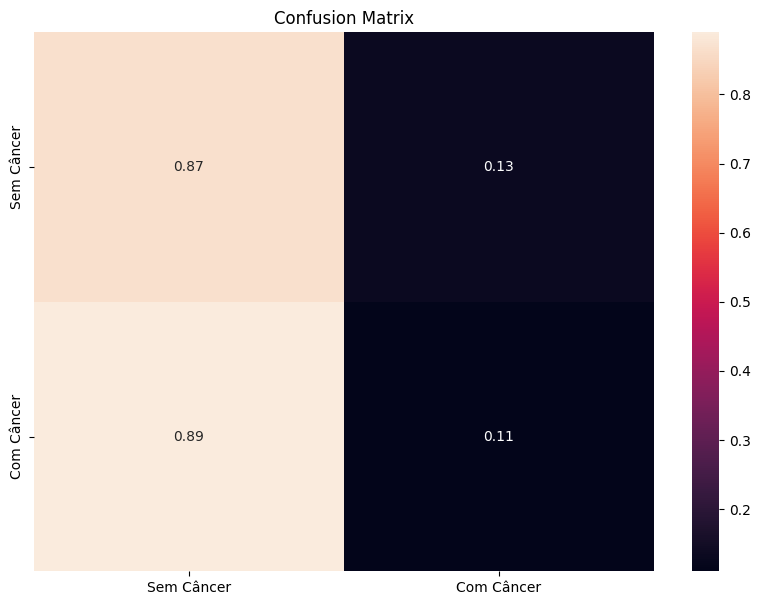

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      8530
           1       0.02      0.11      0.03       218

    accuracy                           0.85      8748
   macro avg       0.50      0.49      0.48      8748
weighted avg       0.95      0.85      0.90      8748

Accuracy: 0.8477366255144033
balanced_accuracy_score: 0.4883401271282145


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score

y_valRF = rclf.predict(feats_val)
print_cmx(y_val, y_valRF)
print(classification_report(y_val, y_valRF))
print("Accuracy: {0}".format(accuracy_score(y_val, y_valRF)))
print("balanced_accuracy_score: {0}".format(balanced_accuracy_score(y_val, y_valRF)))


#### Avaliação de resultados no conjunto de teste

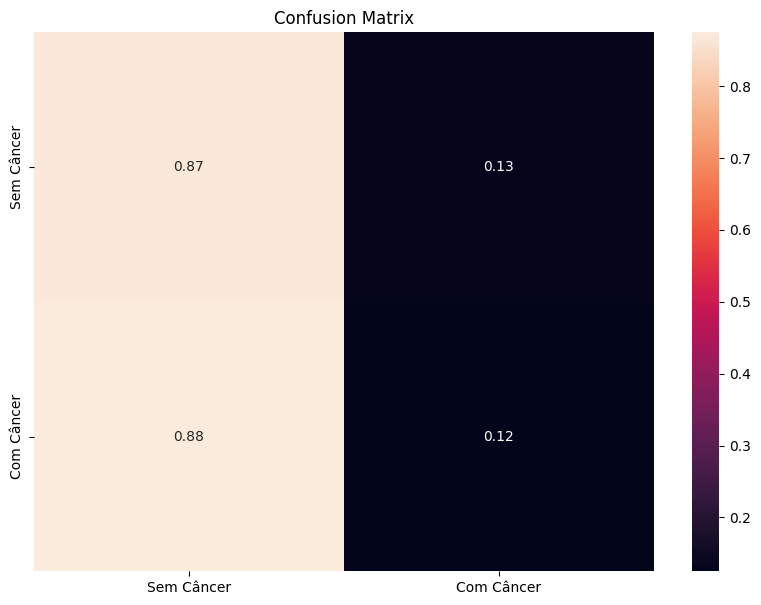

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     10770
           1       0.02      0.12      0.03       192

    accuracy                           0.85     10962
   macro avg       0.50      0.50      0.47     10962
weighted avg       0.97      0.85      0.91     10962

Accuracy: 0.8534026637474913
balanced_accuracy_score: 0.4956940575673166


In [ ]:
y_testRF = rclf.predict(feats_test)
print_cmx(y_test, y_testRF)
print(classification_report(y_test, y_testRF))
print("Accuracy: {0}".format(accuracy_score(y_test, y_testRF)))
print("balanced_accuracy_score: {0}".format(balanced_accuracy_score(y_test, y_testRF)))


### 8° Arquitetura avaliada (densenet121 com camadas descongeladas e dropout para evitar overfitting)

In [116]:
!pip install tensorflow-addons

# Carregamento do modelo pré-treinado SEM a última camada densa (include_top = False)
base_model_desnet = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3))
base_model_desnet.summary()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.5 MB/s eta 0:00:00
29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 64, 64)  9408        ['zero_padding2d[0][0]']         
                                         

In [117]:
# descongelando os pesos da rede
for layer in base_model_desnet.layers:
    layer.trainable = True

model_desnet_desc_drop = tf.keras.Sequential([
  base_model_desnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_desnet_desc_drop.summary() #Note o núúmero de paramêtros treináveis

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


creating generators
Found 34956 images belonging to 2 classes.
Found 10947 images belonging to 2 classes.
Found 8731 images belonging to 2 classes.
ploting model
compiling model
loading best weights
loaded best weights


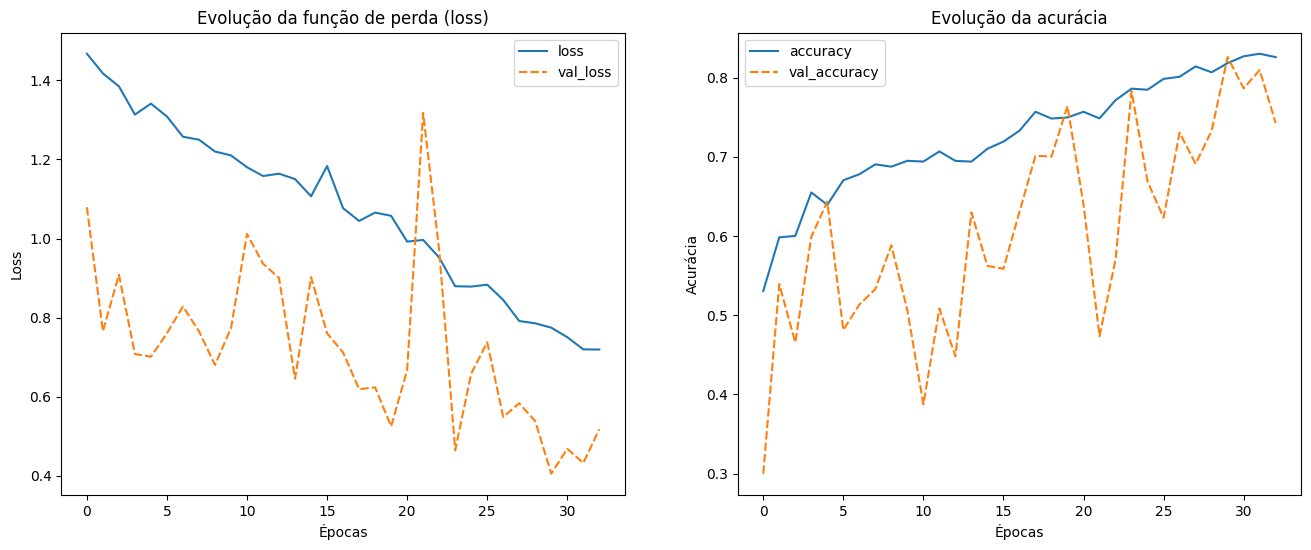

Evaluating Validation set
273/273 [==============================] - 51s 140ms/step
(8731,)
Métrica de avaliação do Kaggle: 0.07725192199844222
Acurácia balanceada: 62.34%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.84      0.90      8514
      Câncer       0.06      0.41      0.10       217

    accuracy                           0.83      8731
   macro avg       0.52      0.62      0.50      8731
weighted avg       0.96      0.83      0.88      8731



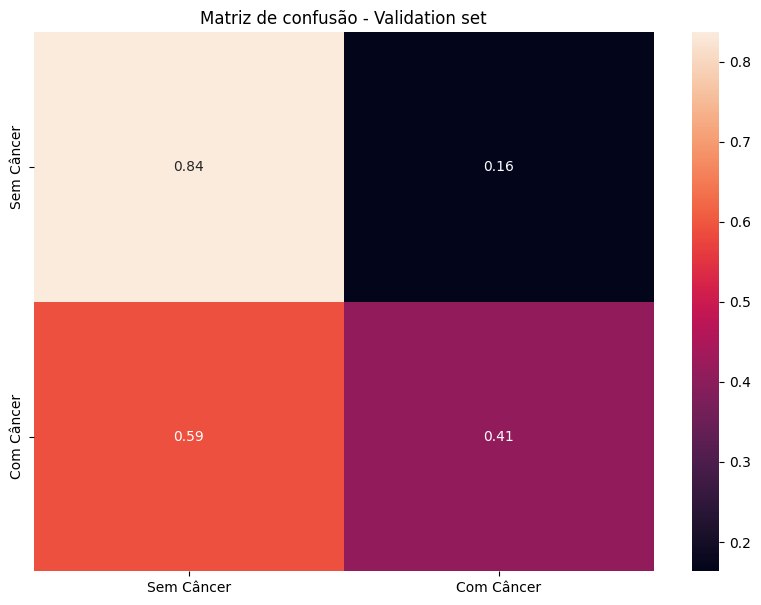

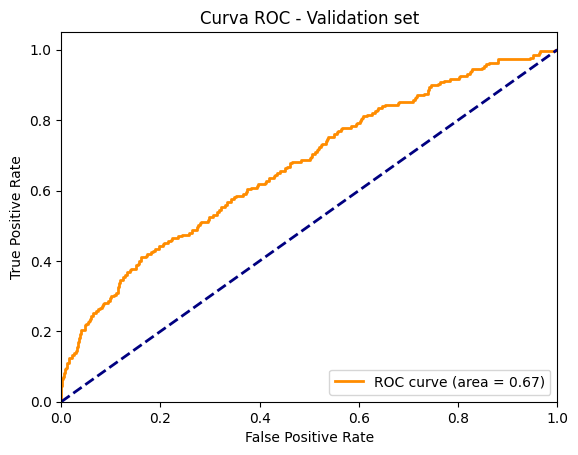

Evaluating Test set
343/343 [==============================] - 43s 126ms/step
(10947,)
Métrica de avaliação do Kaggle: 0.052603490807498855
Acurácia balanceada: 59.86%
              precision    recall  f1-score   support

  Sem Câncer       0.99      0.83      0.90     10755
      Câncer       0.04      0.37      0.07       192

    accuracy                           0.82     10947
   macro avg       0.51      0.60      0.48     10947
weighted avg       0.97      0.82      0.89     10947



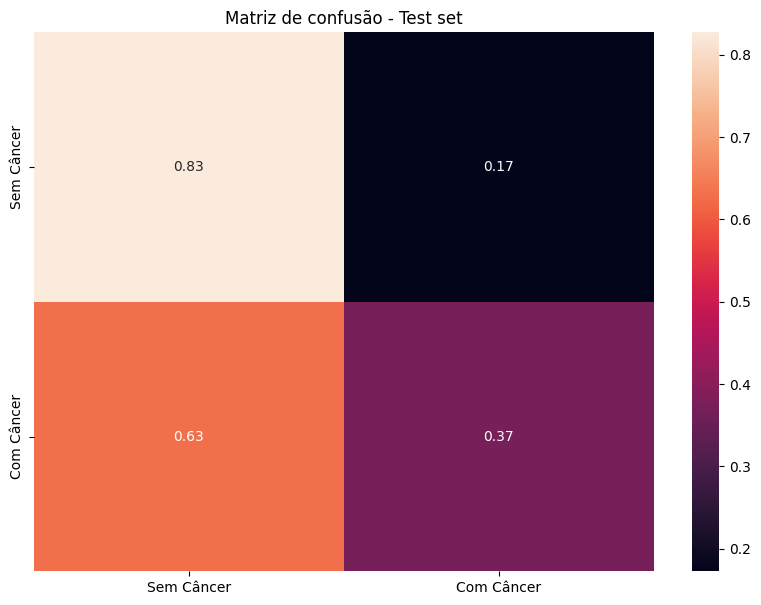

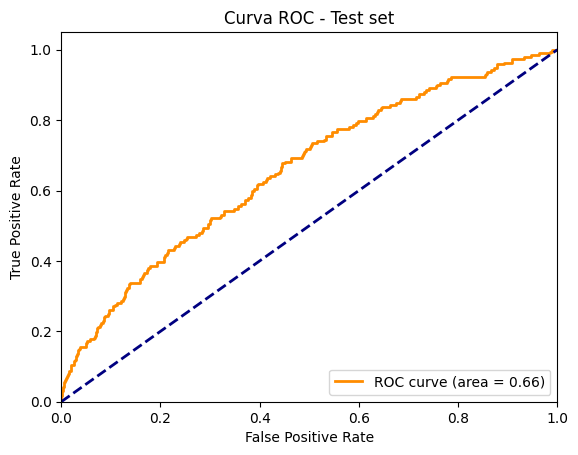

In [118]:
run_keras_train_and_evaluate(
    model = model_desnet_desc_drop,
    train_class_weights = train_class_weights,
    model_identification = 'densenet121-descongelado-dropout',
    preprocessing_function = tf.keras.applications.densenet.preprocess_input,
    run_model_fit = TRAIN_MODEL,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)

## Avaliação de resultados com o modelo vencedor

 - Densenet121 com camadas descongeladas e dropout para evitar overfitting;
 - Imagens redimensionadas para tamanho de 256x128 antes de entregar para a rede neural;
 - Pré-processamento utilizando yolov5 e demais filtros para extração de ROI.

#### Carrega modelo e resultados

creating generators
Found 34956 images belonging to 2 classes.
Found 10947 images belonging to 2 classes.
Found 8731 images belonging to 2 classes.
compiling model
loading best weights
loaded best weights


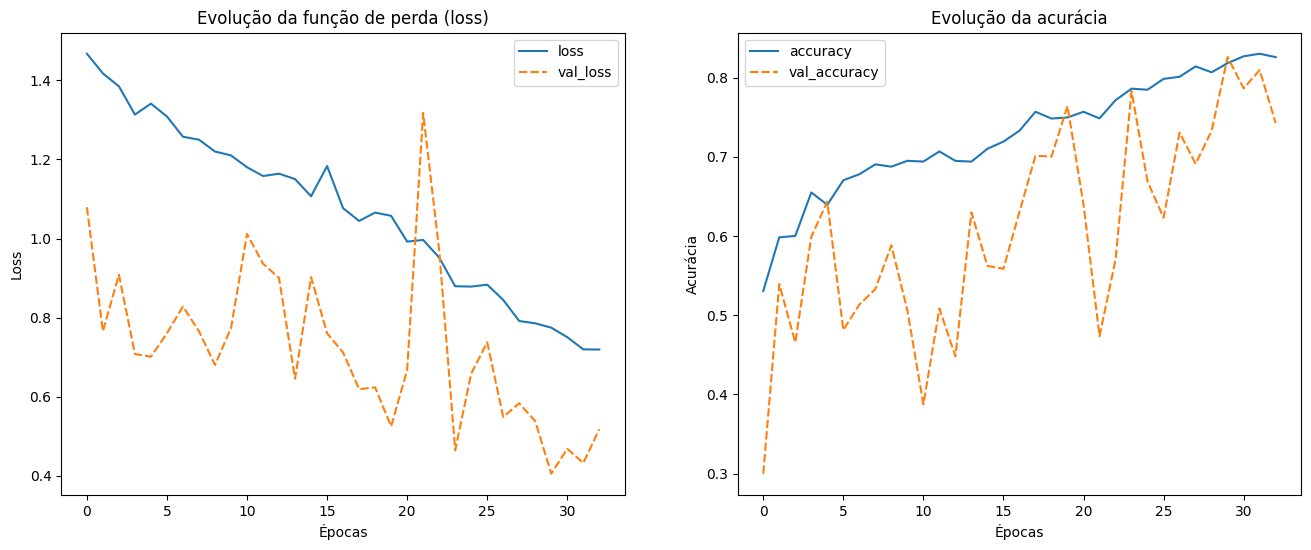

Evaluating Validation set
273/273 [==============================] - 34s 119ms/step
(8731,)
Métrica de avaliação do Kaggle: 0.07725192199844222
Acurácia balanceada: 62.34%
              precision    recall  f1-score   support

  Sem Câncer       0.98      0.84      0.90      8514
      Câncer       0.06      0.41      0.10       217

    accuracy                           0.83      8731
   macro avg       0.52      0.62      0.50      8731
weighted avg       0.96      0.83      0.88      8731



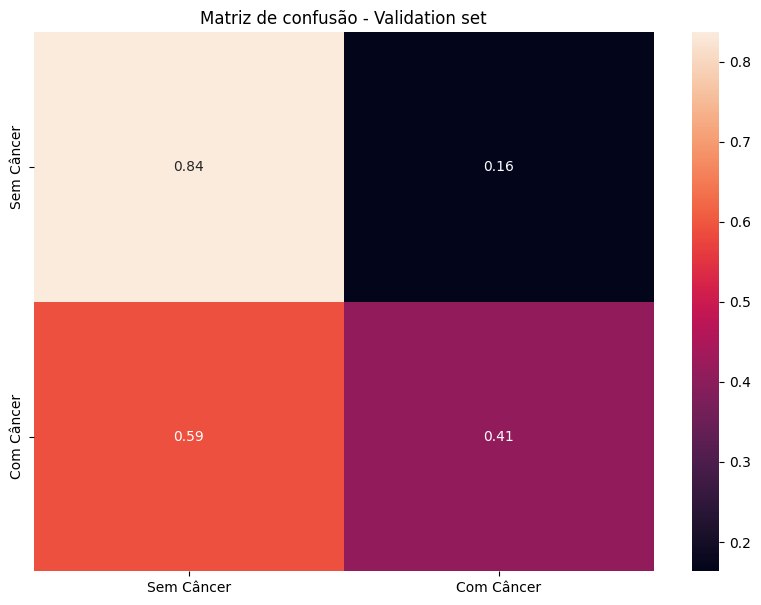

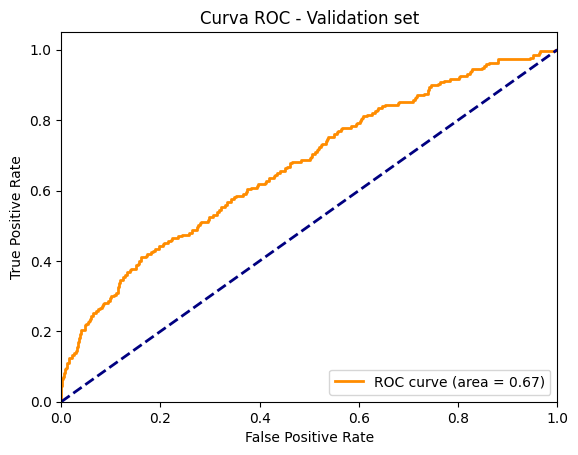

Evaluating Test set
343/343 [==============================] - 41s 119ms/step
(10947,)
Métrica de avaliação do Kaggle: 0.052603490807498855
Acurácia balanceada: 59.86%
              precision    recall  f1-score   support

  Sem Câncer       0.99      0.83      0.90     10755
      Câncer       0.04      0.37      0.07       192

    accuracy                           0.82     10947
   macro avg       0.51      0.60      0.48     10947
weighted avg       0.97      0.82      0.89     10947



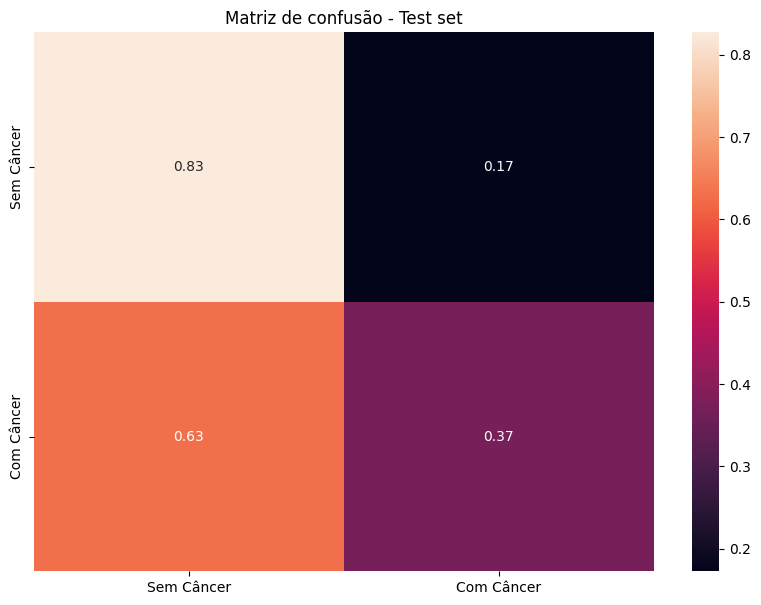

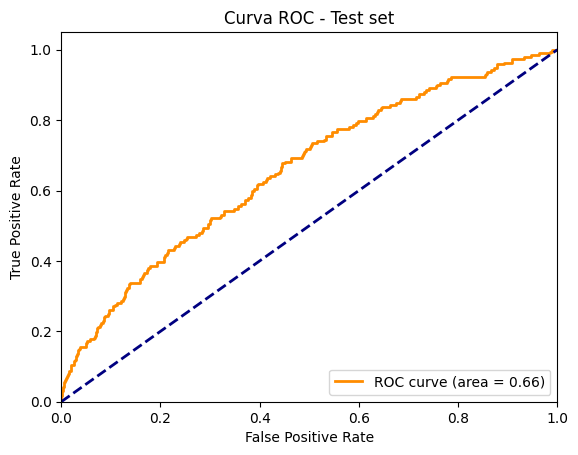

In [130]:
winner_model = run_keras_train_and_evaluate(
    model = model_desnet_desc_drop,
    train_class_weights = train_class_weights,
    model_identification = 'densenet121-descongelado-dropout',
    preprocessing_function = tf.keras.applications.densenet.preprocess_input,
    run_model_fit = TRAIN_MODEL,
    loss_function = 'binary_crossentropy',
    metrics_list = binary_metrics,
    generator_class_mode='binary',
    evaluate_image_set_function=evaluate_image_set_binary,
    optimizer_class=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
)

#### Cria geradores de imagens para calcular métricas por paciente, no conjunto de teste

In [ ]:
train_generator, test_generator, validation_generator = create_generators(
    preprocessing_function = tf.keras.applications.densenet.preprocess_input,
    target_size = TARGET_SIZE,
    class_mode = 'binary'
)

Found 34956 images belonging to 2 classes.
Found 10947 images belonging to 2 classes.
Found 8731 images belonging to 2 classes.


#### Realiza predição no conjunto de Teste e organiza vetor com 0 ou 1s

In [ ]:
import re
test_image_ids = [re.findall(r'\d+', filename)[1] for filename in test_generator.filenames]

y_pred = winner_model.predict(test_generator)
preds=np.transpose(y_pred)[0]  # transformation to get (n,)
print(preds.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
test_predictions = list(map(lambda x: 0 if x<0.5 else 1, preds))

df_test_predictions = pd.DataFrame(list(zip(test_image_ids, test_predictions)),
               columns =['image_id', 'prediction'])


validation_ids = [re.findall(r'\d+', filename)[1] for filename in validation_generator.filenames]
y_pred = winner_model.predict(validation_generator)
preds=np.transpose(y_pred)[0]  # transformation to get (n,)
print(preds.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
validation_predictions = list(map(lambda x: 0 if x<0.5 else 1, preds))

df_validation_predictions = pd.DataFrame(list(zip(validation_ids, validation_predictions)),
               columns =['image_id', 'prediction'])

343/343 [==============================] - 40s 115ms/step
(10947,)
273/273 [==============================] - 32s 116ms/step
(8731,)


#### Monta dataset agregando por paciente
Tanto na coluna de predição, quanto na coluna original, é considerando positivo pra cancer se ao menos uma imagem indicar positivo

In [ ]:
df_test_predictions.image_id = df_test_predictions.image_id.astype('int')
df_test_real_with_pred = df_test[['patient_id','image_id', 'cancer', 'difficult_negative_case']].merge(df_test_predictions, on='image_id', how='left')

df_test_real_with_pred.difficult_negative_case = df_test_real_with_pred.difficult_negative_case.astype('int')
df_test_real_with_pred.loc[df_test_real_with_pred.difficult_negative_case == False,'difficult_negative_case'] = 0
df_test_real_with_pred.loc[df_test_real_with_pred.difficult_negative_case == True,'difficult_negative_case'] = 1

df_test_gb_patient = df_test_real_with_pred.groupby('patient_id')['cancer', 'prediction', 'difficult_negative_case'].sum().reset_index()
df_test_gb_patient.loc[df_test_gb_patient.cancer > 0,'cancer'] = 1
df_test_gb_patient.loc[df_test_gb_patient.prediction > 0,'prediction'] = 1
df_test_gb_patient.loc[df_test_gb_patient['difficult_negative_case'] > 0,'difficult_negative_case'] = 1
df_test_gb_patient

<ipython-input-62-6a0bd63c1a73>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_test_gb_patient = df_test_real_with_pred.groupby('patient_id')['cancer', 'prediction', 'difficult_negative_case'].sum().reset_index()


,patient_id,cancer,prediction,difficult_negative_case
0,5,0,1.0,1
1,30,0,1.0,0
2,65,0,0.0,0
3,72,0,1.0,0
4,105,0,1.0,0
...,...,...,...,...
2378,65309,0,1.0,1
2379,65431,0,0.0,0
2380,65477,0,0.0,0
2381,65492,1,1.0,0


#### Acurácia balanceada por paciente

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score

print(classification_report(df_test_gb_patient.cancer, df_test_gb_patient.prediction))
print("Accuracy: {0}".format(accuracy_score(df_test_gb_patient.cancer, df_test_gb_patient.prediction)))
print("balanced_accuracy_score: {0}".format(balanced_accuracy_score(df_test_gb_patient.cancer, df_test_gb_patient.prediction)))

              precision    recall  f1-score   support

           0       0.98      0.51      0.68      2303
           1       0.05      0.72      0.09        80

    accuracy                           0.52      2383
   macro avg       0.52      0.62      0.38      2383
weighted avg       0.95      0.52      0.66      2383

Accuracy: 0.522031053294167
balanced_accuracy_score: 0.619990230134607


#### Acurácia balanceada por paciente (sem considerar casos considerados difíceis)

In [ ]:
df_test_gb_patient_without_difficult_cases = df_test_gb_patient[df_test_gb_patient.difficult_negative_case == 0]

print(classification_report(df_test_gb_patient_without_difficult_cases.cancer, df_test_gb_patient_without_difficult_cases.prediction))
print("Accuracy: {0}".format(accuracy_score(df_test_gb_patient_without_difficult_cases.cancer, df_test_gb_patient_without_difficult_cases.prediction)))
print("balanced_accuracy_score: {0}".format(balanced_accuracy_score(df_test_gb_patient_without_difficult_cases.cancer, df_test_gb_patient_without_difficult_cases.prediction)))

              precision    recall  f1-score   support

           0       0.98      0.55      0.70      1706
           1       0.07      0.73      0.13        78

    accuracy                           0.56      1784
   macro avg       0.52      0.64      0.41      1784
weighted avg       0.94      0.56      0.68      1784

Accuracy: 0.5571748878923767
balanced_accuracy_score: 0.6400036071782848
